# Problem Statement

## Context

### Problem Statement

Kampanye penawaran pembukaan term deposit (deposito) akan membutuhkan banyak waktu dan sumber day jika perusahaan menargetkan semua nasabah tanpa melakukan penyaringan. Pihak bank ingin meningkatkan efesiensi penawaran dengan mengetahui nasabah mana yang kemungkinan besar ingin membuka term deposit (deposito).

### Goals

Melihat dari permasalahan yang dimiliki, maka bank ingin memiliki kemampuan untuk memprediksi kemungkinan seorang nasabah untuk membuka term deposit atau tidak, sehingga dapat memfokuskan penawaran pada nasabah yang bersedia.

Dan juga, bank ingin mengetahui apa/factor/variable yang membuat seorang nasabah ingin membuka term deposit (deposito) atau tidak, sehingga divisi marketing dapat membuat rencana lebih baik dalam mendekati nasabah potensial.

### Analytic Approach 

Jadi yang akan dilakukan adalah menganalisis data untuk menemukan pola yang membedakan nasabah yang mau membuka term deposit atau tidak.

Kemudian akan dibangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang kandidat akan/ingin membuka term deposit (deposito) atau tidak.

### Metriks Evaluasi

![Alt text](me.jpg)

Type 1 error : False Positive

Konsekuensi : Sia-sianya biaya penawaran, waktu dan sumber daya

Type 2 error : False Negative

Konsekuensi : Kehilangan Nasabah Potensial.

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import plotly.express as px
from IPython.display import display
from plotnine import *
import plotnine

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
import category_encoders as ce
from sklearn.preprocessing import FunctionTransformer
import scipy.stats as stats
from sklearn.feature_selection import RFE, RFECV

# Model Selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, precision_recall_curve, matthews_corrcoef
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)


# DATA UNDERSTANDING

Data Source : https://archive.ics.uci.edu/ml/datasets/bank+marketing

Bank Marketing Campaign

Sebuah dataset yang mendeskripsikan hasil kampanye market sebuah bank di Portugal. Kampanye dilakukan kebanyakan lewat telepon, menawarkan klien untuk melakukan deposito. Jika setuju makan target variabel akan diisi oleh ‘yes’ selain itu ‘no’


Deposito : jenis rekening deposito dimana dana yang ada akan dikunci dalam jjangka waktu tertentu.

Feature description

Bank client data:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

Related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

social and economic context attributes

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

* Data set tidak seimbang
* terdapat 41188 data dengan 20 fitur
* 10 fitur kategorikal dan 10 fitur numerical

In [2]:
#Load Dataset
df = pd.read_csv('data-bank.csv',sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
# display(df.describe(), df.describe(include='object'))

In [5]:
# listItem = []
# for col in df.columns :
#     listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
#                     df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

# dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
#                      data=listItem)
# dfDesc

# Explaratory Data Analysis

## Distribusi

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
df.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


## Korelasi

In [8]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [9]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.00,0.52,0.42,0.24,0.24,0.00,0.02,0.13,0.29,0.06,0.00,0.00,0.18,0.13,0.18,0.27,0.26,0.36,0.29,0.30,0.22
job,0.52,1.00,0.38,0.67,0.32,0.02,0.02,0.16,0.26,0.03,0.02,0.00,0.18,0.13,0.22,0.33,0.30,0.25,0.29,0.34,0.20
marital,0.42,0.38,1.00,0.25,0.10,0.01,0.00,0.11,0.08,0.01,0.00,0.00,0.06,0.07,0.04,0.10,0.11,0.12,0.15,0.11,0.08
education,0.24,0.67,0.25,1.00,0.26,0.02,0.00,0.16,0.20,0.03,0.00,0.00,0.07,0.06,0.07,0.12,0.20,0.13,0.18,0.13,0.09
default,0.24,0.32,0.10,0.26,1.00,0.04,0.01,0.08,0.19,0.02,0.00,0.04,0.05,0.12,0.24,0.35,0.33,0.23,0.24,0.31,0.06
housing,0.00,0.02,0.01,0.02,0.04,1.00,0.94,0.05,0.09,0.02,0.00,0.05,0.00,0.03,0.06,0.12,0.16,0.07,0.08,0.10,0.01
loan,0.02,0.02,0.00,0.00,0.01,0.94,1.00,0.01,0.03,0.01,0.00,0.05,0.00,0.00,0.00,0.03,0.04,0.02,0.02,0.02,0.00
contact,0.13,0.16,0.11,0.16,0.08,0.05,0.01,1.00,0.77,0.04,0.04,0.07,0.18,0.32,0.15,0.63,0.67,0.54,0.62,0.68,0.23
month,0.29,0.26,0.08,0.20,0.19,0.09,0.03,0.77,1.00,0.16,0.07,0.10,0.31,0.26,0.37,0.85,0.89,0.94,0.80,0.83,0.36
day_of_week,0.06,0.03,0.01,0.03,0.02,0.02,0.01,0.04,0.16,1.00,0.02,0.03,0.01,0.00,0.02,0.05,0.09,0.11,0.22,0.07,0.02


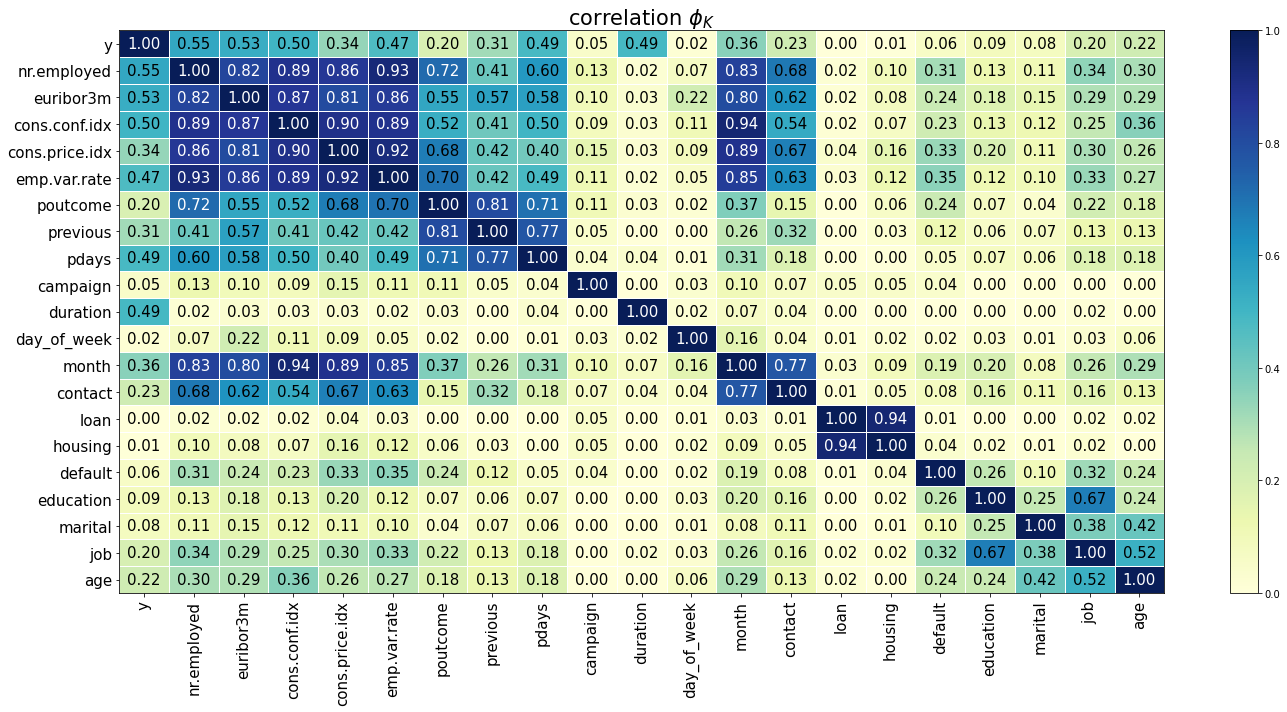

In [10]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="YlGnBu", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

## Kardinalitas Data

In [11]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)])

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,78,"[47, 56]"
1,job,object,0,0.0,12,"[blue-collar, admin.]"
2,marital,object,0,0.0,4,"[married, unknown]"
3,education,object,0,0.0,8,"[high.school, basic.6y]"
4,default,object,0,0.0,3,"[yes, unknown]"
5,housing,object,0,0.0,3,"[no, yes]"
6,loan,object,0,0.0,3,"[yes, no]"
7,contact,object,0,0.0,2,"[telephone, cellular]"
8,month,object,0,0.0,10,"[jul, apr]"
9,day_of_week,object,0,0.0,5,"[mon, thu]"


## Data Duplikat

In [12]:
print(df[df.duplicated(keep=False)].shape)
df[df.duplicated(keep=False)]

(24, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


Terdapat total 24 kolom yang memiliki value yang sama.

Dataset sudah tidak memiliki data duplikat.

## Mengubah data UNKNOWN menjadi NaN 

In [13]:
list_unknown = []
cat_unknown = []
pct_unk = []
for cat in df.columns:
    if df[cat].dtype == 'object':
        cat_unknown.append(cat)
        list_unknown.append([cat,df[cat][df[cat] == 'unknown'].count(),f'{(df[cat][df[cat] == "unknown"].count()/df[cat].count() * 100).round(2)} %'])
        pct_unk.append(df[cat][df[cat] == 'unknown'].count())

df_unknown = pd.DataFrame(columns=['Column','f Unknown','Unknown %'],data =list_unknown)

df_unknown.sort_values(by = ['f Unknown'],ascending=False)

,Column,f Unknown,Unknown %
3,default,8597,20.87 %
2,education,1731,4.2 %
4,housing,990,2.4 %
5,loan,990,2.4 %
0,job,330,0.8 %
1,marital,80,0.19 %
6,contact,0,0.0 %
7,month,0,0.0 %
8,day_of_week,0,0.0 %
9,poutcome,0,0.0 %


Memperlihatkan jumlah baris dan persentase data unknown di tiap kolom kategorikalnya.

In [14]:
# Replace 'unknown' with NaN in multiple columns
df = df.replace({'unknown': pd.np.nan})

Merubah nilai unknown menjadi Nan.

### Visualisasi Nan dengan MissingNo Library

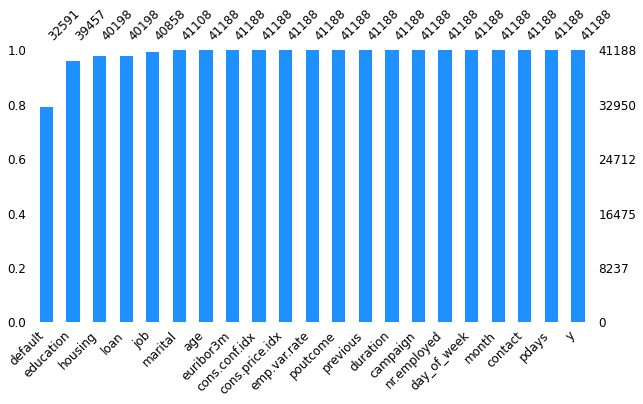

In [15]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

terlihat default, education, housing, loan, job, dan marital memiliki data unknown

<AxesSubplot:>

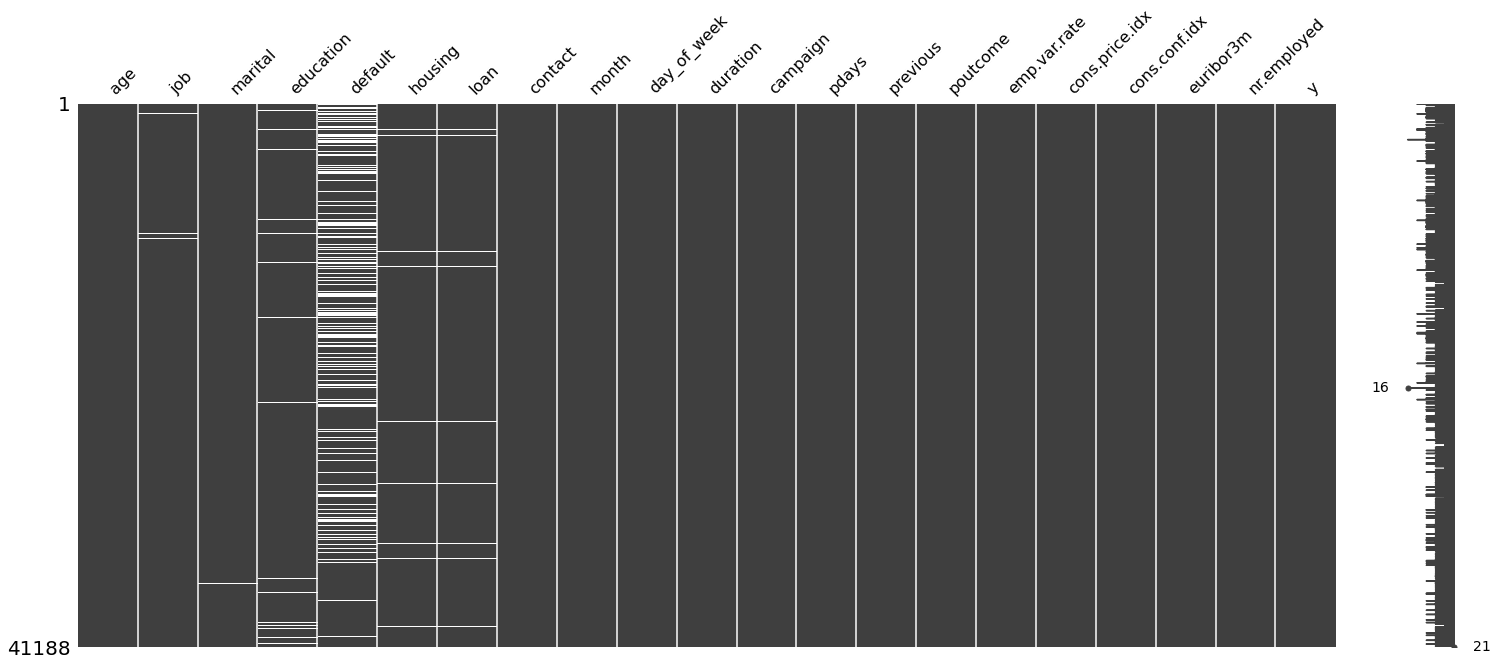

In [16]:
missingno.matrix(df)

In [17]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


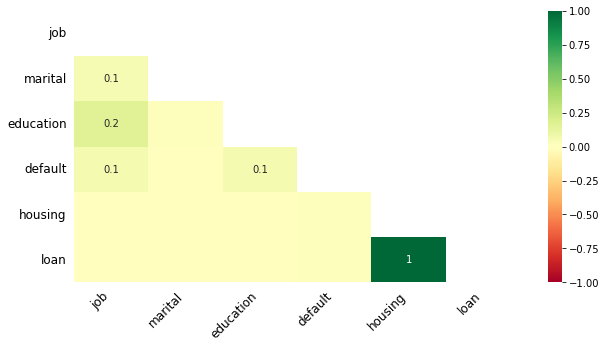

In [18]:
missingno.heatmap(df, cmap="RdYlGn", figsize=(10,5), fontsize=12);

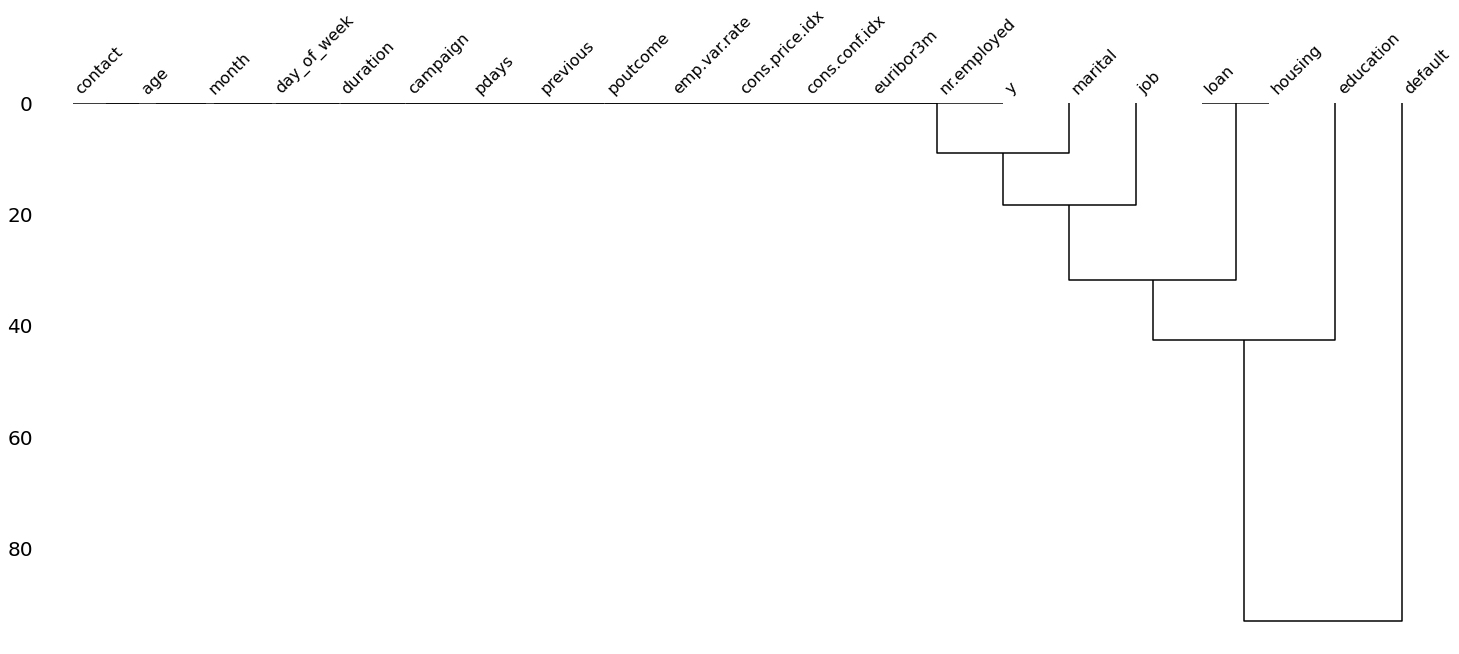

In [19]:
missingno.dendrogram(df)
plt.show()

dari matrix, heatmap dan dendogram diatas dapat disimpulkan bahwa

* data loan dan housing memiliki kekosongan yang sama dimana ini menandakan lebih baik mengisinya dengan data yang sama
* pada kolom default terdapat 20% data yang kosong
* kolom job dan kolom education terdapat korelasi diantara data yang kosongnya.

## Check Outlier

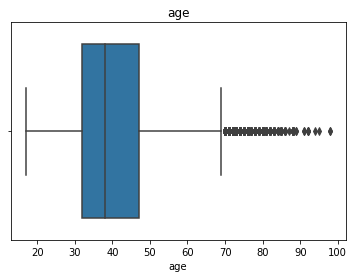

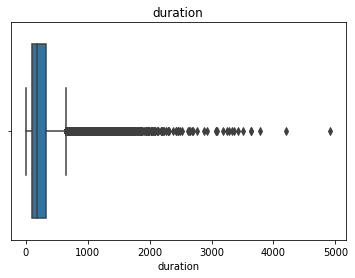

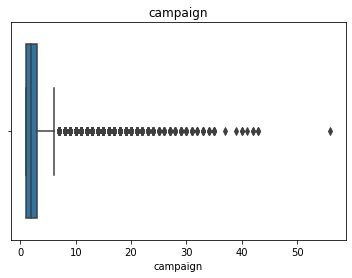

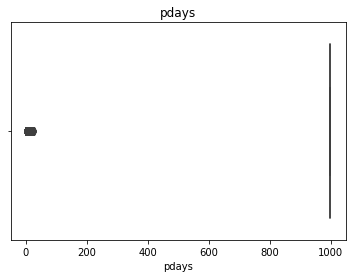

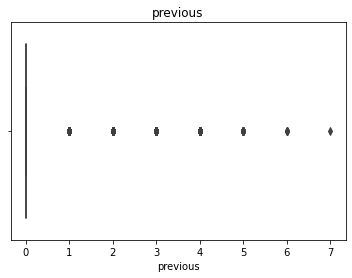

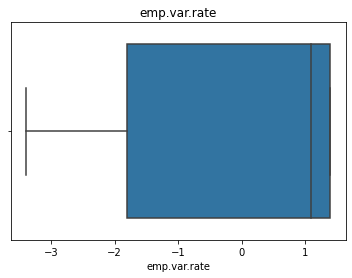

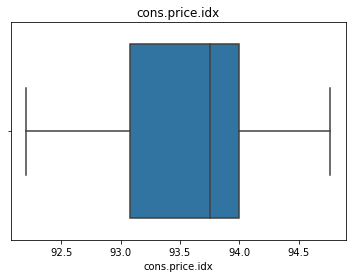

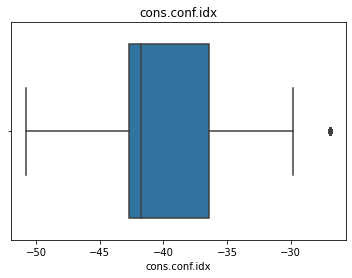

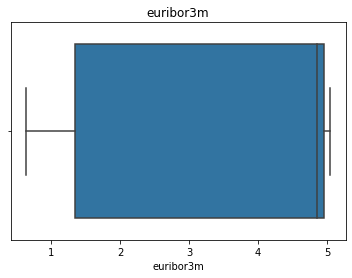

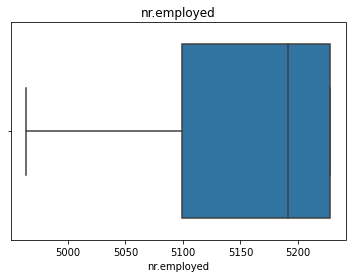

In [20]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# create boxplots for numerical columns
for col in num_cols:
    plt.figure()
    sns.boxplot(data=df, x=col)
    plt.title(col)


In [21]:
df['age'].unique()

array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
       49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
       28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
       77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
       74, 17, 87, 91, 86, 98, 94, 84, 92, 89], dtype=int64)

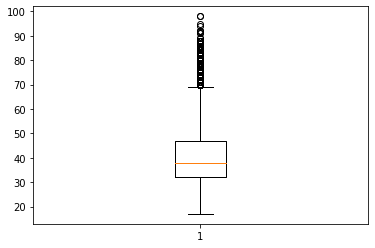

In [22]:
plt.boxplot(df['age'])
plt.show()

In [23]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]
print(f"Jumlah data oulier pada kolom Age : {len(outliers)}")


Jumlah data oulier pada kolom Age : 469


In [24]:
out_all=outliers.pivot_table(columns='age', index=['y'], aggfunc='size')
out_all['Total']=out_all.sum(axis =1)
out_all.sort_values('Total',ascending=False)

age,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,91,92,94,95,98,Total
y,,,,,,,,,,,,,,,,,,,,,,,,,,
no,28.0,32.0,21.0,21.0,17.0,13.0,16.0,7.0,13.0,7.0,13.0,12.0,6.0,9.0,4.0,8.0,3.0,NaN,13.0,NaN,2.0,1.0,1.0,1.0,NaN,248.0
yes,19.0,21.0,13.0,13.0,15.0,11.0,18.0,13.0,14.0,7.0,18.0,8.0,11.0,8.0,3.0,7.0,5.0,1.0,9.0,2.0,NaN,3.0,NaN,NaN,2.0,221.0


In [25]:
df['y'] = df['y'].replace({'yes': 1, 'no': 0})


replace data y dengan 1 = yes dan 0 = no

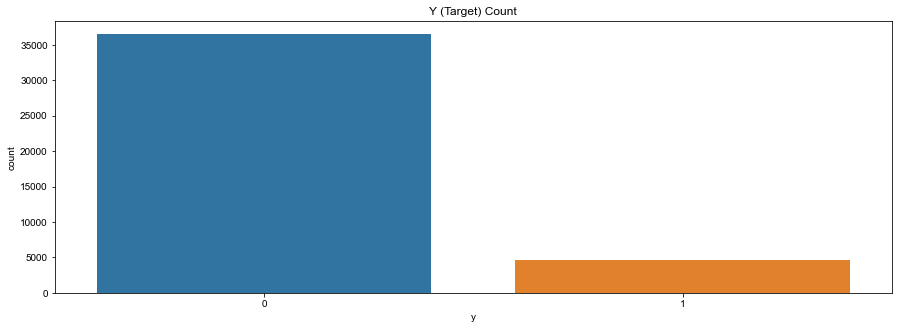

In [26]:
plt.figure(figsize=(15, 5))
sns.countplot(x='y', data=df)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Y (Target) Count')
plt.show()

Dari visualisasi kolom Target dapat dilihat bawah targetnya imbalance.

In [27]:
# count = 0
# fig = plt.figure(figsize=(20,20))

# for i in df.drop(columns=['y','default','day_of_week','age','emp.var.rate','nr.employed','euribor3m','cons.conf.idx','cons.price.idx','housing','loan']).columns:
#     count +=1
#     ax= plt.subplot(5,2,count)
#     pd.crosstab(df[i],df['y'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
#     fig.tight_layout()


# plt.show()

In [28]:
# import matplotlib.pyplot as plt

# # Select categorical columns
# cat_cols = df.select_dtypes(include=['object']).columns

# # Determine number of rows and columns needed for subplots
# num_plots = len(cat_cols)
# num_cols = 2
# num_rows = (num_plots + 1) // num_cols

# # Create subplots
# fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,20))

# # Loop through each categorical column and create a countplot
# for i, col in enumerate(cat_cols):
#     row = i // num_cols
#     pos = i % num_cols
#     ax = axs[row, pos]
#     df[col].value_counts().plot(kind='bar', ax=ax)
#     ax.set_title(col)

# # Adjust layout and display plot
# fig.tight_layout()
# plt.show()


### Categorical Columns

#### Job

Text(0.5, 1.0, 'Job Count')

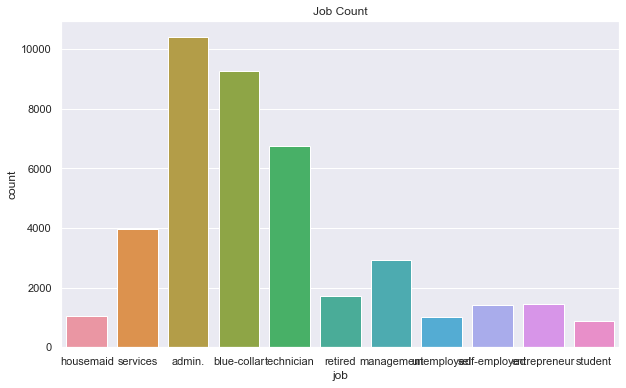

In [29]:
sns.countplot(data = df, x = 'job')
sns.set(rc={'figure.figsize':(20,8)})
plt.title('Job Count')

Text(0.5, 1.0, 'Job Count Based on Target')

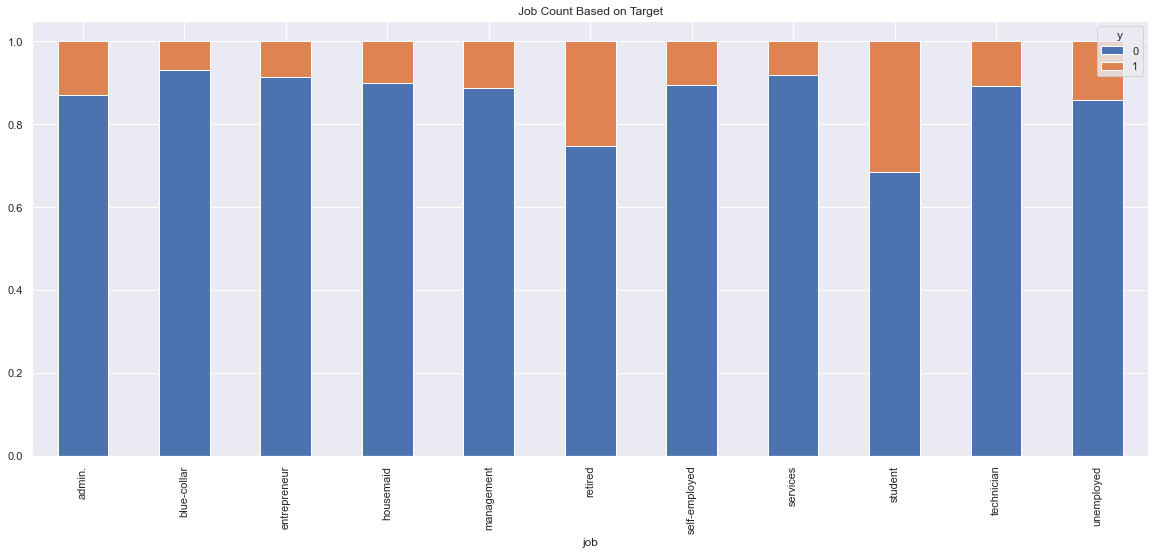

In [30]:
Job=pd.crosstab(df["job"],df['y'])
Job.div(Job.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,8))
plt.title('Job Count Based on Target')

Dari visualisasi diatas dapat dilihat bahwa student dan retired memiliki acceptance rate tertinggi terhadap penawaran term deposit.

In [31]:
df_JY=df.pivot_table(columns='y', index=['job'], aggfunc='size')
df_JY['Total']=df_JY.sum(axis =1) 
df_JY.sort_values('Total', ascending=False)

y,0,1,Total
job,,,
admin.,9070,1352,10422
blue-collar,8616,638,9254
technician,6013,730,6743
services,3646,323,3969
management,2596,328,2924
retired,1286,434,1720
entrepreneur,1332,124,1456
self-employed,1272,149,1421
housemaid,954,106,1060


namun jika dilihat dari data terbanyak yang melakukan deposit. ada pada job admin dengan 1352 customer yang akan melakukan termdeposit.

#### Poutcome

Text(0.5, 1.0, 'P Outcome Count')

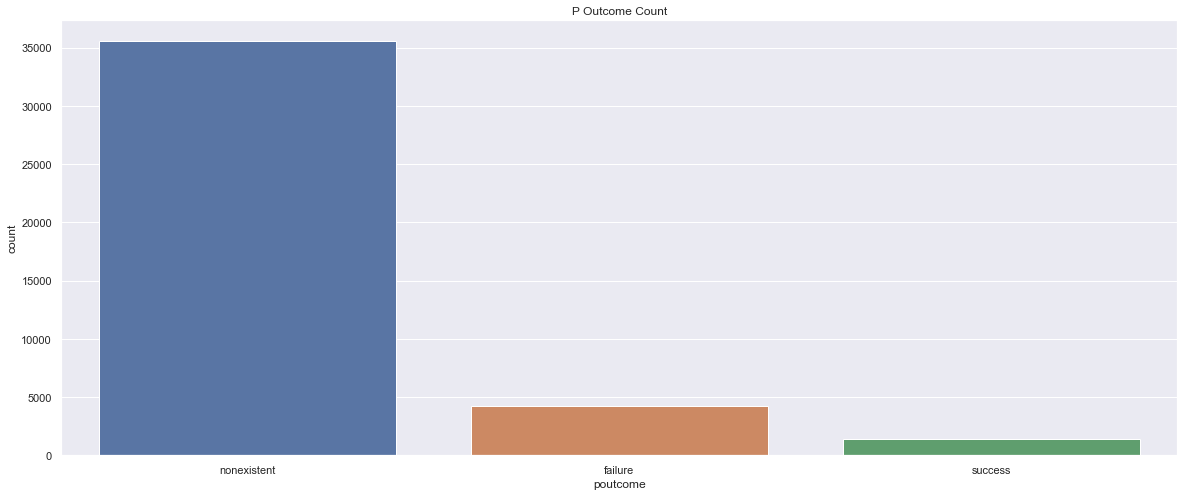

In [32]:
sns.countplot(data = df, x = 'poutcome')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('P Outcome Count')

Text(0.5, 1.0, 'P Outcome Count Based on Target')

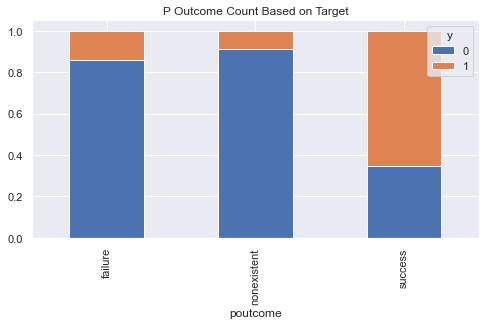

In [33]:
Poutcome=pd.crosstab(df["poutcome"],df['y'])
Poutcome.div(Poutcome.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(8,4))
sns.set(rc={'figure.figsize':(10,6)})
plt.title('P Outcome Count Based on Target')

In [34]:
df_P=df.pivot_table(columns='y', index=['poutcome'], aggfunc='size')
df_P['Total']=df_P.sum(axis =1) 
df_P.sort_values('Total', ascending=False )

y,0,1,Total
poutcome,,,
nonexistent,32422,3141,35563
failure,3647,605,4252
success,479,894,1373


Dari visualisasi diatas dapat dilihat bahwa mereka yang `succes`/ sudah pernah melakukan deposito sebelumnya memiliki kemungkinan terbesar untuk melakukan term deposit kembali. dengan jumlah yang akan melakukan deposito sebanyak 894 customer dari deposit sebelumnya. jika jumlah terbanyak datang dari customer yang belum pernah ditawarkan deposito `nonexistent` dengan jumlah sebanyak 3141 customer deposito baru.

#### Day of the week

Text(0.5, 1.0, 'Day of the Week Count')

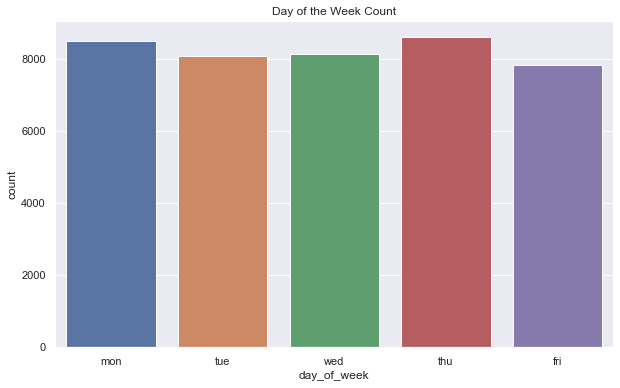

In [35]:
sns.countplot(data = df, x = 'day_of_week')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Day of the Week Count')

Text(0.5, 1.0, 'Day of the Week Count Based on Target')

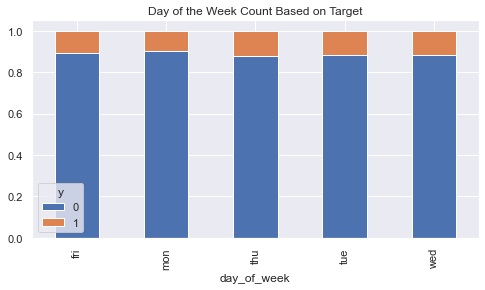

In [36]:
Day=pd.crosstab(df["day_of_week"],df['y'])
Day.div(Day.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(8,4))
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Day of the Week Count Based on Target')

In [37]:
df_D=df.pivot_table(columns='y', index=['day_of_week'], aggfunc='size')
df_D['Total']=df_D.sum(axis =1) 
df_D.sort_values('Total', ascending=False )

y,0,1,Total
day_of_week,,,
thu,7578,1045,8623
mon,7667,847,8514
wed,7185,949,8134
tue,7137,953,8090
fri,6981,846,7827


dari visualisasi diatas dapat dilihat bahwa penawaran hanya dilakukan di hari kerja dan total rata rata penawaran perharinya sebanyak 8.238 customer yang ditawarkan selama periode campaign berlangsung. dengan acceptance rate tertinggi ada pada hari kamis, walaupun tidak berbeda jauh dengan hari hari lainnya 

#### Month

Text(0.5, 1.0, 'Month Count')

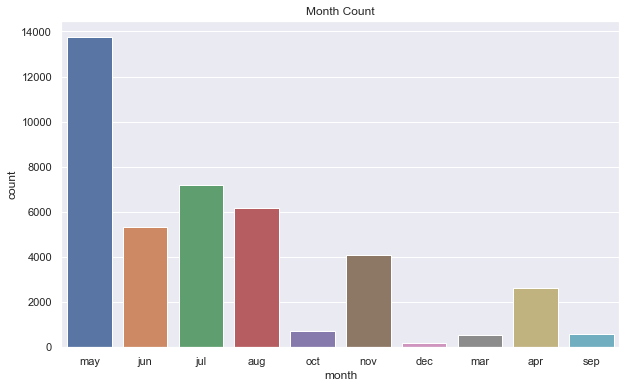

In [38]:
sns.countplot(data = df, x = 'month')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Month Count')

Text(0.5, 1.0, 'Month Count Based on Target')

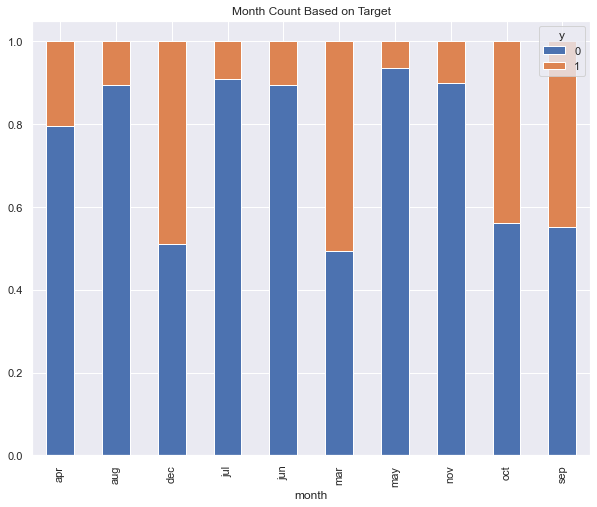

In [39]:
Month=pd.crosstab(df["month"],df['y'])
Month.div(Month.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(10,8))
plt.title('Month Count Based on Target')

In [40]:
df_cl=df.pivot_table(columns='y', index=['month'], aggfunc='size')
df_cl['Total']=df_cl.sum(axis =1) 
df_cl.sort_values('Total', ascending=False )

y,0,1,Total
month,,,
may,12883,886,13769
jul,6525,649,7174
aug,5523,655,6178
jun,4759,559,5318
nov,3685,416,4101
apr,2093,539,2632
oct,403,315,718
sep,314,256,570
mar,270,276,546


dari visualisasi diatas dapat dilihat bahwa proses penawaran paling banyak dilakukan pada bulan Mei dengan jumlah data 13.769 customer yang di tawarkan, tetapi acceptance rate tertinggi seorang nasabah melakukan pembukaan rekening terdapat pada bulan Maret, Desember, Oktober dan September

#### Contact

Text(0.5, 1.0, 'Contact Count')

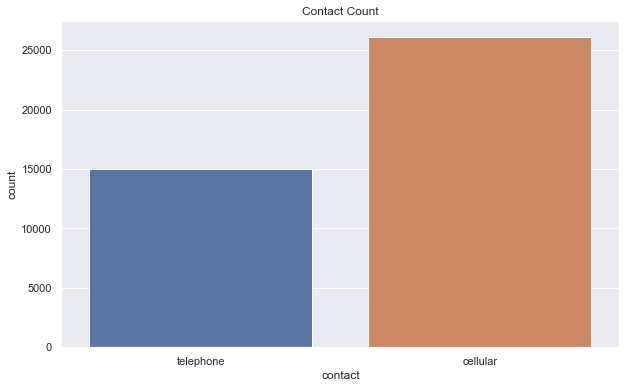

In [41]:
sns.countplot(data = df, x = 'contact')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Contact Count')

Text(0.5, 1.0, 'Contact Count Based on Target')

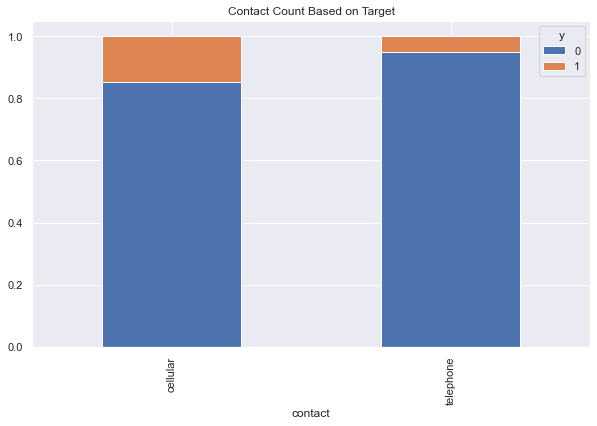

In [42]:
Contact=pd.crosstab(df["contact"],df['y'])
Contact.div(Contact.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Contact Count Based on Target')

In [43]:
df_cl=df.pivot_table(columns='y', index=['contact'], aggfunc='size')
df_cl['Total']=df_cl.sum(axis =1) 
df_cl.sort_values('Total', ascending=False )

y,0,1,Total
contact,,,
cellular,22291,3853,26144
telephone,14257,787,15044


pada visualisasi diatas dapat disimpulkan bahwa kegiatan campaign ini lebih banyak dilakukan menggunakan nomer celullar dibandingkan menggunakan nomer telephone. dengan perbandingan 26144 melalui cellular dan 15044 data melalui telephone 

#### Marital

Text(0.5, 1.0, 'Marital Count')

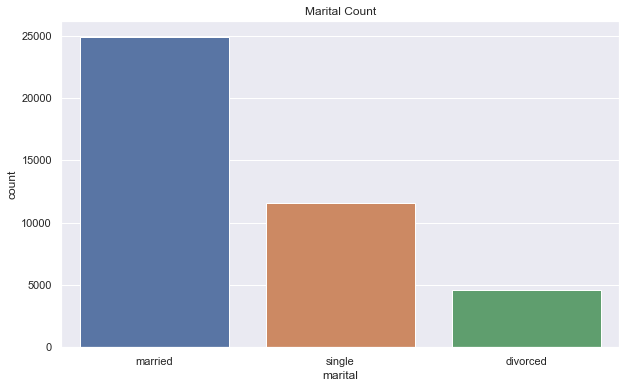

In [44]:
sns.countplot(data = df, x = 'marital')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Marital Count')

Text(0.5, 1.0, 'Marital Count Based on Target')

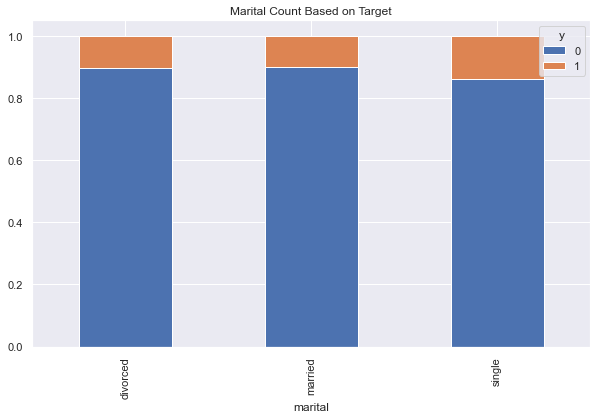

In [45]:
Marital=pd.crosstab(df["marital"],df['y'])
Marital.div(Marital.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Marital Count Based on Target')

dilihat pada visualisasi data diatas, tidak terlihat perbedaan yang signifikan antara masing masing status perkawinan. acceptance rate tertinggi ada pada `single` namun, customer terbanyak yang disurvey memiliki status perkawinan '`married`' atau sudah menikah.

#### Loan

Text(0.5, 1.0, 'Loan Count')

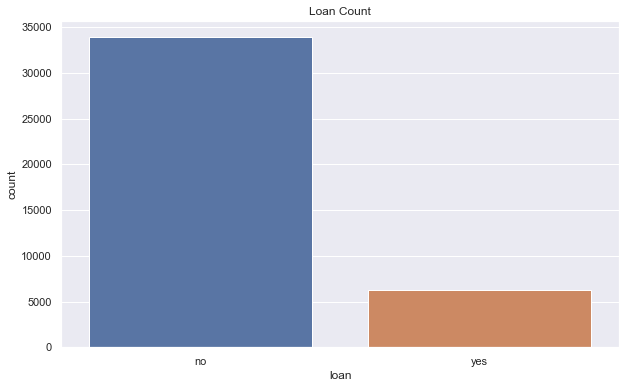

In [46]:
sns.countplot(data = df, x = 'loan')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Loan Count')

Text(0.5, 1.0, 'Loan Count Based on Target')

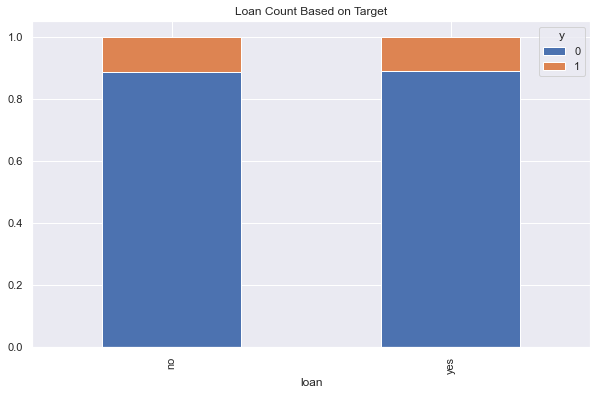

In [47]:
Loan=pd.crosstab(df["loan"],df['y'])
Loan.div(Loan.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Loan Count Based on Target')

Nasabah yang lebih sering dihubungi adalah mereka yang tidak memiliki loan pada bank, meskipun ada atau tidak adanya loan tidak terlalu mempengaruhi rasio pembukaan rekening deposito.

#### Housing

Text(0.5, 1.0, 'Housing Count')

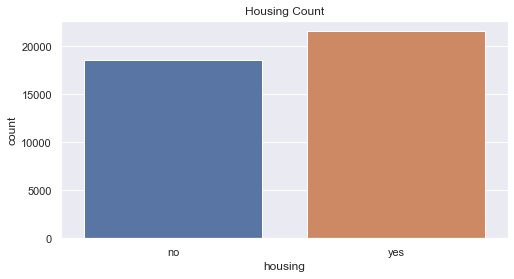

In [48]:
sns.countplot(data = df, x = 'housing')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Housing Count')

Text(0.5, 1.0, 'Housing Count Based on Target')

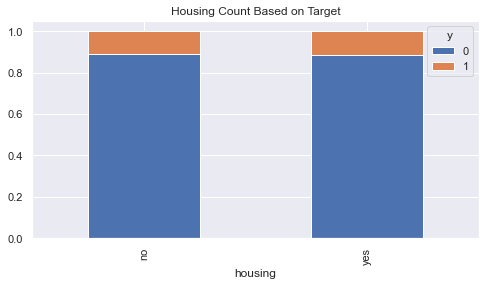

In [49]:
Housing=pd.crosstab(df["housing"],df['y'])
Housing.div(Housing.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Housing Count Based on Target')

Nasabah yang lebih sering dihubungi adalah mereka yang memiliki housing loan pada bank, meskipun ada atau tidak adanya housing loan tidak terlalu mempengaruhi rasio pembukaan rekening deposito.

#### Default

Text(0.5, 1.0, 'Default Count')

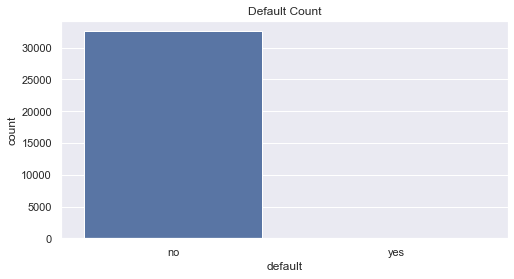

In [50]:
sns.countplot(data = df, x = 'default')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Default Count')

Text(0.5, 1.0, 'Default Count Based on Target')

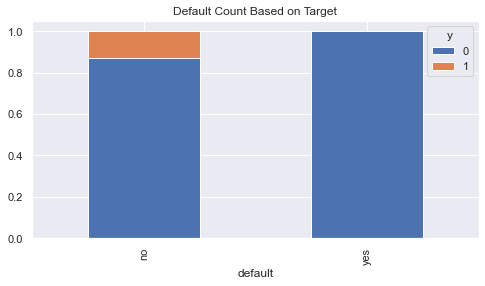

In [51]:
Default=pd.crosstab(df["default"],df['y'])
Default.div(Default.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Default Count Based on Target')

Bagi yang default nya memiliki value yes tidak ada yang melakukan pembukaan rekening deposito

#### Education

Text(0.5, 1.0, 'Education')

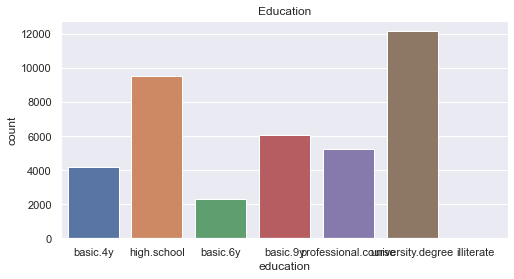

In [52]:
sns.countplot(data = df, x = 'education')
sns.set(rc={'figure.figsize':(20,8)})
plt.title('Education')

Text(0.5, 1.0, 'Education Count Based on Target')

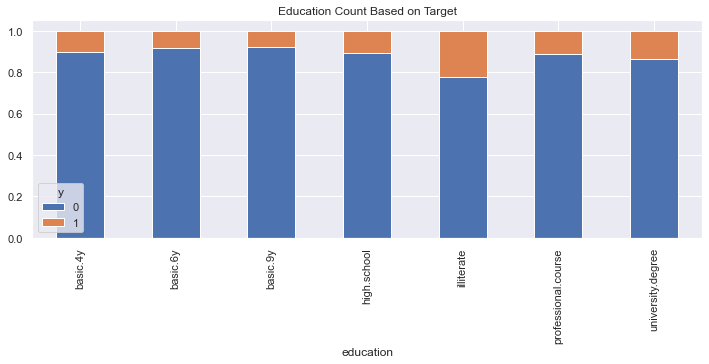

In [53]:
Default=pd.crosstab(df["education"],df['y'])
Default.div(Default.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(12,4))
plt.title('Education Count Based on Target')

In [54]:
df[df['education'] == 'illiterate'].groupby('y')['education'].value_counts()

y  education 
0  illiterate    14
1  illiterate     4
Name: education, dtype: int64

Dari visualisasi data dapat dilihat bahwa illiterate memiliki kemungkinan terbesar dalam pembukaan rekening term deposit. walaupun dari jumlah datanya hanya 18 data. secara asumsi seharusnya acceptance rate tertinggi ada pada pendidikan yang lebih tinggi yaitu university.degree dan ini sesuai dengan data campaign dimana acceptance rate tinggi juga ada pada unversity degree dengan jumlah data terbanyak ada pada kategori unversity.degree.

### Numerical Features

In [55]:
num_column = []
lst_nunique = []
for cat in df.columns:
    if df[cat].dtype != 'object' and cat != 'y' :
        num_column.append(cat)
        lst_nunique.append([cat,df[cat].nunique()])

df_num = pd.DataFrame(columns=['Column','f Unique'],data =lst_nunique)

df_num


,Column,f Unique
0,age,78
1,duration,1544
2,campaign,42
3,pdays,27
4,previous,8
5,emp.var.rate,10
6,cons.price.idx,26
7,cons.conf.idx,26
8,euribor3m,316
9,nr.employed,11


#### Number of Employees

Text(0.5, 1.0, 'Number of Employees Distribution based on target')

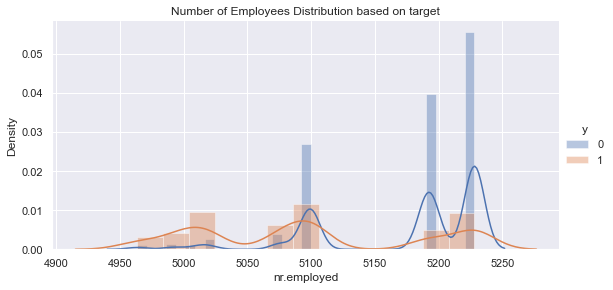

In [56]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'nr.employed').add_legend()
plt.title('Number of Employees Distribution based on target')

Text(0.5, 1.0, 'Number of Employees Count')

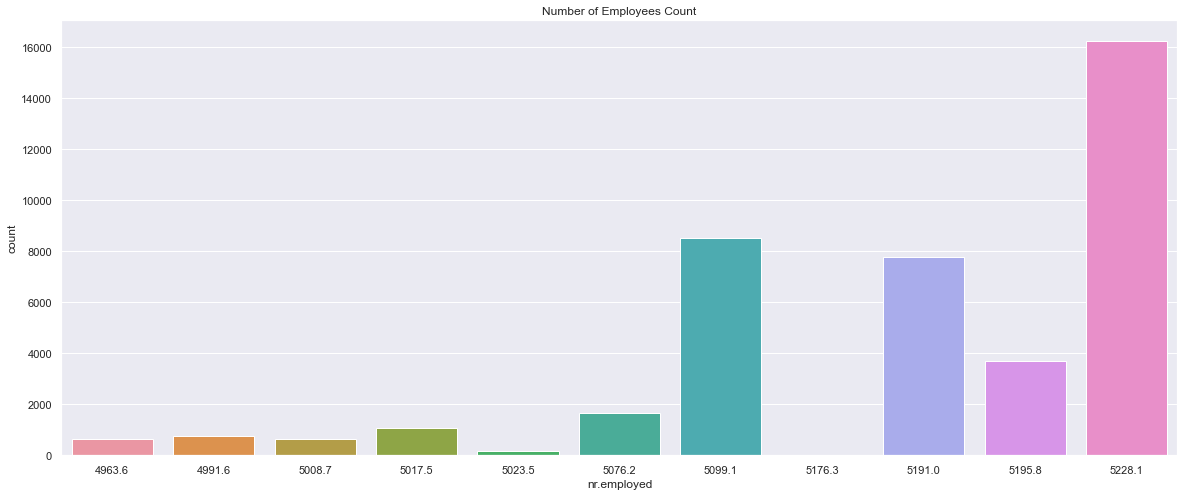

In [57]:
sns.countplot(data = df , x = 'nr.employed')
plt.title('Number of Employees Count')

Text(0.5, 1.0, 'Number of Employees Count based on Target')

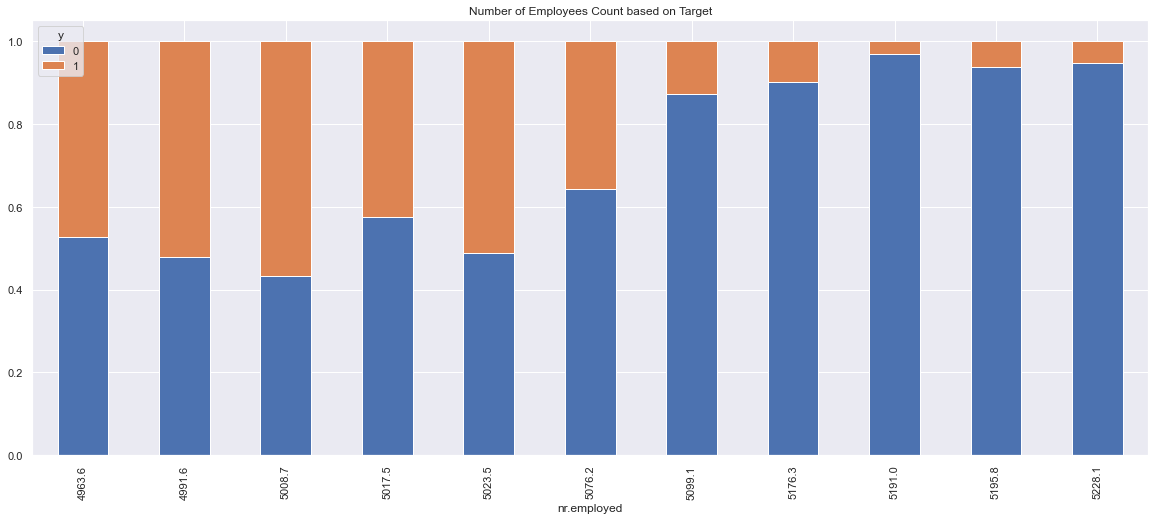

In [58]:
NE=pd.crosstab(df["nr.employed"],df['y'])
NE.div(NE.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(20,8)})
plt.title('Number of Employees Count based on Target')

#### Euro Interbank Offered Rate

Text(0.5, 1.0, 'Euribor3m Distribution based on target')

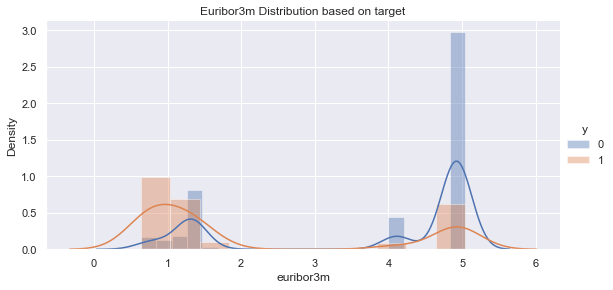

In [59]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'euribor3m').add_legend()
plt.title('Euribor3m Distribution based on target')

#### Consumer Confidence

Text(0.5, 1.0, 'Consumer Confidence Distribution based on target')

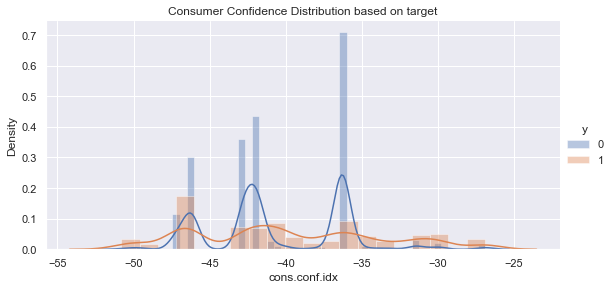

In [60]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'cons.conf.idx').add_legend()
plt.title('Consumer Confidence Distribution based on target')

In [61]:
df['cons.conf.idx'].unique()

array([-36.4, -41.8, -42.7, -36.1, -40.4, -42. , -45.9, -50. , -47.1,
       -46.2, -40.8, -33.6, -31.4, -29.8, -26.9, -30.1, -33. , -34.8,
       -34.6, -40. , -39.8, -40.3, -38.3, -37.5, -49.5, -50.8])

#### Consumer Price

Text(0.5, 1.0, 'Consumer Confidence Index Distribution based on target')

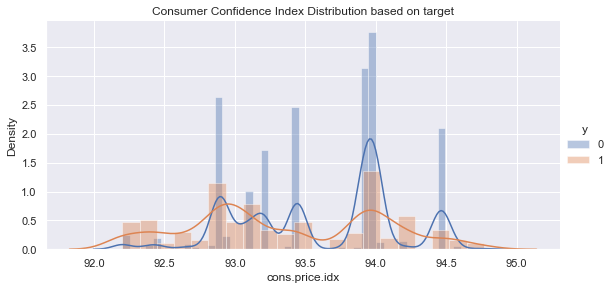

In [62]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'cons.price.idx').add_legend()
plt.title('Consumer Confidence Index Distribution based on target')

#### Employment Variation Rate

Text(0.5, 1.0, 'Employee Variation Rate Distribution based on target')

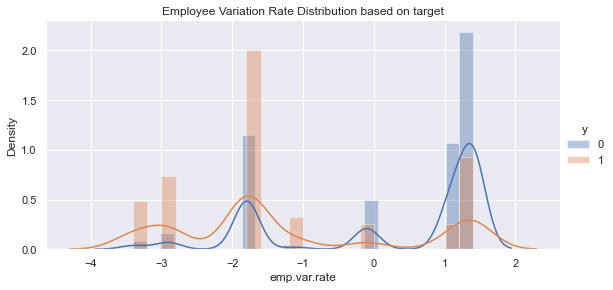

In [63]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'emp.var.rate').add_legend()
plt.title('Employee Variation Rate Distribution based on target')

In [64]:
df['emp.var.rate'].unique()

array([ 1.1,  1.4, -0.1, -0.2, -1.8, -2.9, -3.4, -3. , -1.7, -1.1])

#### Previous

Text(0.5, 1.0, 'Previous Count')

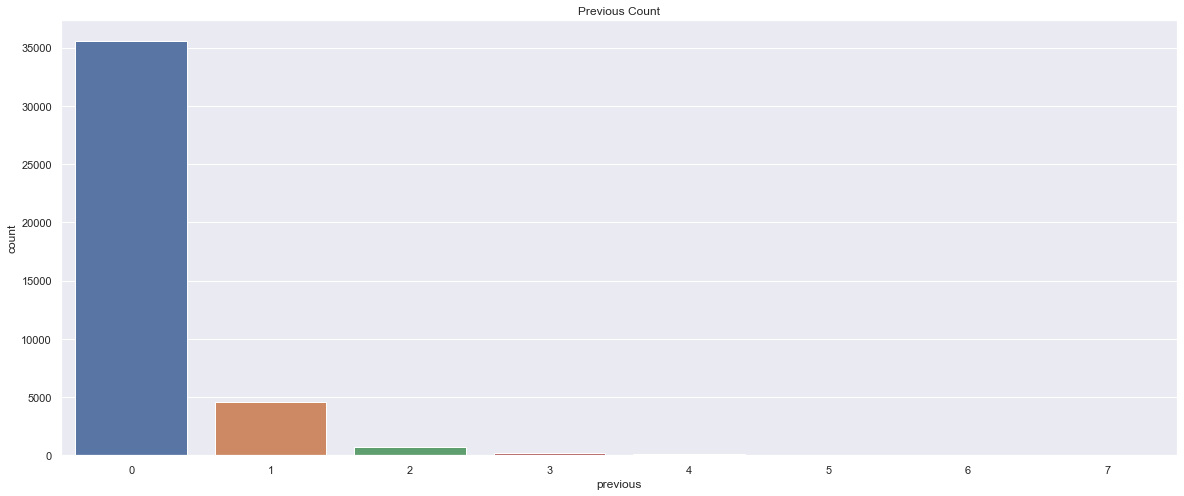

In [65]:
sns.countplot(data = df , x = 'previous')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Previous Count')

Text(0.5, 1.0, 'Previous Count based on Target')

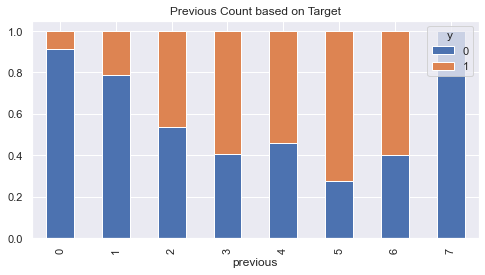

In [66]:
Previous=pd.crosstab(df["previous"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Previous Count based on Target')

Dari visualisasi diatas dilihat bahwa maksimal pihak bank melakukan 7 kali kontak sebelum kampanye pembukaan term deposit terhadap seorang nasabah.

#### pdays

Text(0.5, 1.0, 'Pdays Box Plot')

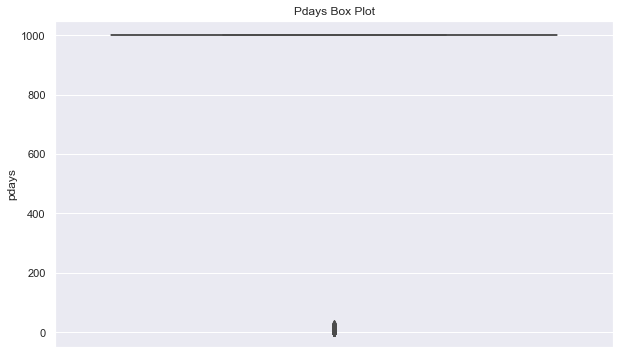

In [67]:
sns.boxplot(data = df , y = 'pdays')
plt.title('Pdays Box Plot')

Text(0.5, 1.0, 'Pdays Count')

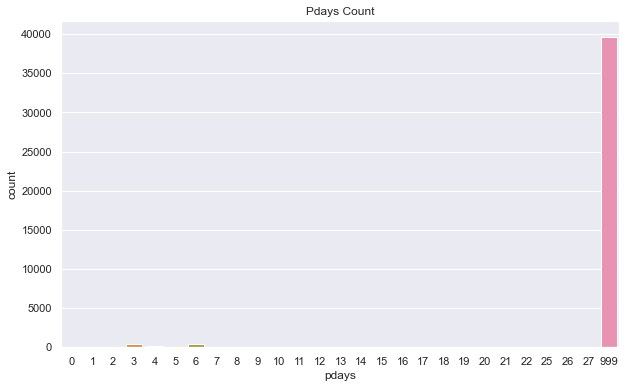

In [68]:
sns.countplot(data = df , x = 'pdays')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Pdays Count')

Text(0.5, 1.0, 'Pdays Count based on Target')

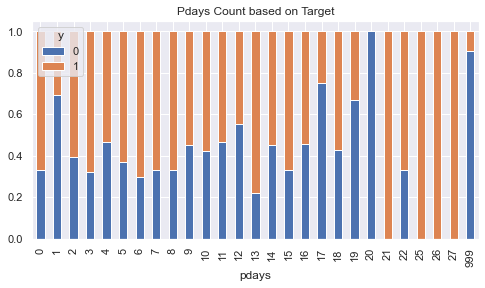

In [69]:
Previous=pd.crosstab(df["pdays"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(12,6)})
plt.title('Pdays Count based on Target')

In [70]:
df['pdays'].unique()

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20], dtype=int64)

Dari visualisasi diatas dapat dilihat bahwa kolom pdays memiliki lompatan nilai yang jauh dari 27 ke 999, hal ini dikarenakan untuk 999 merupakan label untuk nasabah yang belum menerima penawaran sebelumnya.

#### Campaign

Text(0.5, 1.0, 'Campaign Boxplot')

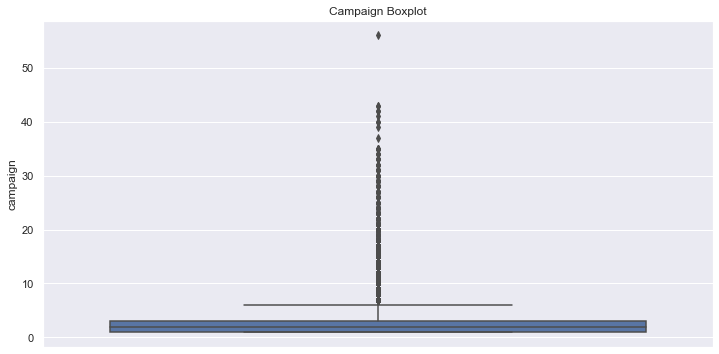

In [71]:
sns.boxplot(data = df , y = 'campaign')
plt.title('Campaign Boxplot')

Text(0.5, 1.0, 'Pdays Count')

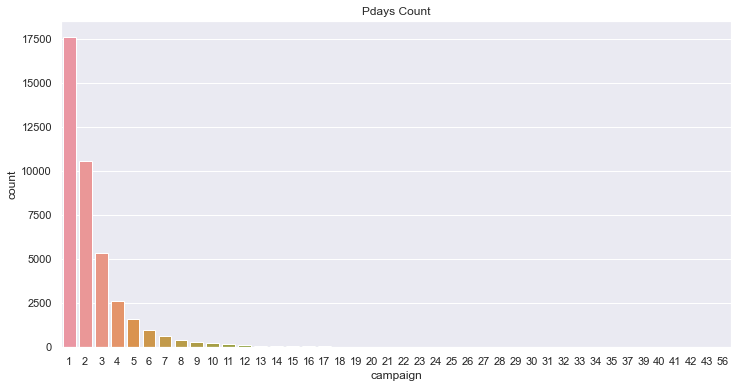

In [72]:
sns.countplot(data = df , x = 'campaign')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Pdays Count')

Text(0.5, 1.0, 'Pdays count based on target')

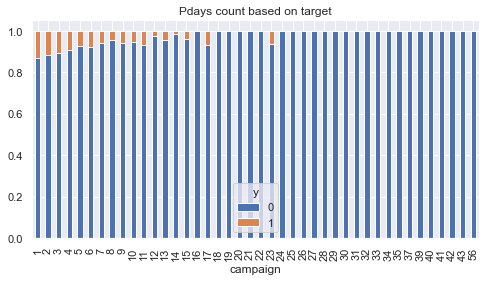

In [73]:
Previous=pd.crosstab(df["campaign"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(18,8)})
plt.title('Pdays count based on target')

#### Age

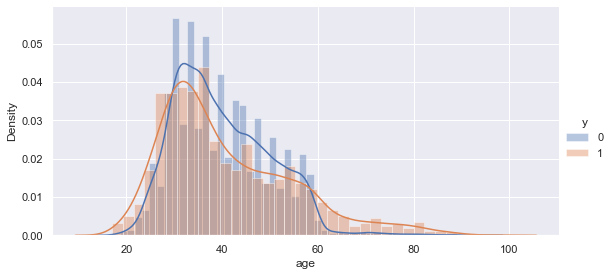

In [74]:
sns.FacetGrid(df, hue='y',height=4,aspect=2).map(sns.distplot, 'age').add_legend()

#### Duration

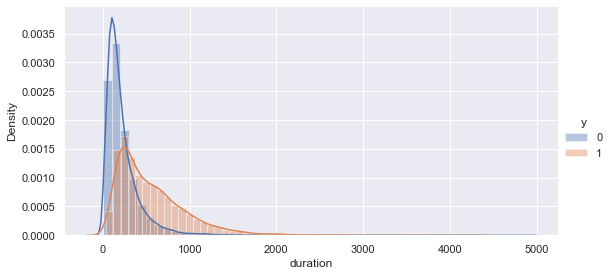

In [75]:
sns.FacetGrid(df, hue='y',height=4,aspect=2).map(sns.distplot, 'duration').add_legend()

Semakin lama durasi maka semakin besar probabilitas seorang nasabah melakukan pembukaan rekening term deposit.

#

## Preprocessing

In [76]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Handling Duplicate

In [77]:
df.drop_duplicates(keep='last',inplace=True)

Menghapus data duplikat dengan menyimpan hanya 1 kemunculannya, yaitu yang terakhir.

In [78]:
df[df.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


### Handling Missing Values

#### Mengisi kolom Housing & Loan

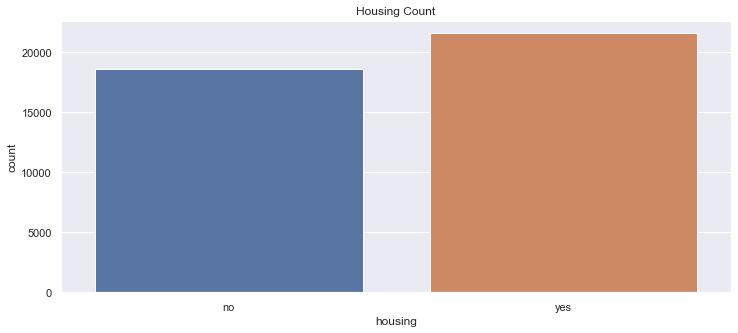

In [79]:
plt.figure(figsize=(12,5))
plt.title('Housing Count')
sns.countplot(data=df, x='housing')
plt.show()

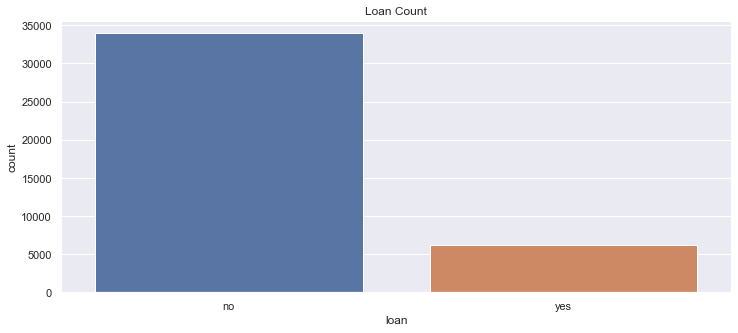

In [80]:
plt.figure(figsize=(12,5))
plt.title('Loan Count')
sns.countplot(data=df, x='loan')
plt.show()

In [81]:
list_housing_loan = []

count = (df['housing'] == 'yes') & (df['loan'] == 'yes')
list_housing_loan.append(['Yes','Yes',count.sum()])
count1 = (df['housing'] == 'yes') & (df['loan'] == 'no')
list_housing_loan.append(['Yes','No',count1.sum()])
count2 = (df['housing'] == 'no') & (df['loan'] == 'yes')
list_housing_loan.append(['No','Yes',count2.sum()])
count3 = (df['housing'] == 'no') & (df['loan'] == 'no')
list_housing_loan.append(['No','No',count3.sum()])

pd.DataFrame(columns=['Housing','Loan','Count'],data=list_housing_loan)

,Housing,Loan,Count
0,Yes,Yes,3691
1,Yes,No,17880
2,No,Yes,2557
3,No,No,16058


In [82]:
# create a contingency table
contingency_table = pd.crosstab(df['housing'], df['loan'])

# perform chi-square test
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# print results
print("Chi-square statistic:", chi2)
print("p-value:", p_value)
if p_value < 0.05:
    print("Conclusion: There is a significant correlation between {} and {}".format('housing', 'loan'))
else:
    print("Conclusion: There is no significant correlation between {} and {}".format('housing', 'loan'))

Chi-square statistic: 86.40975000179616
p-value: 1.4626203966233582e-20
Conclusion: There is a significant correlation between housing and loan


terdapat hubungan corelasi positive yang leman namun sangat berkorelasi secara statistika

In [83]:
df['housing'].fillna('no', inplace=True)
df['loan'].fillna('no', inplace=True)

kami mengisi kolom housing dan loan dengan data yang sama yaitu no dan no dikarenakan :
1.  asumsi bahwa unknown disini dapat diartikan karena memang tidak ditemukannya data peminjaman uang maupun cicilan rumah dari nasabah yang di survey.

2. data housing dan loan sendiri seharusnya sudah dapat dipastikan isinya jika sistem di pengawasan keuangan di portugal sudah terintegritas dengan baik 

3. asumsi bahwa nasabah jikalaupun memiliki hutang / cicilan diluar dari jasa bank (pribadi).

4. jika dilihat dari perbandingan diatas antara yes,yes dan no,no lebih banyak data no,no. dikarenakan data yang kosong memiliki korelasi antara keduanya maka data akan diisi dengan value yang sama dengan harapan tidak akan merubah keseimbangan data secara signifikan terhadap dataset

#### Mengisi Kolom Education dan Job secara bersamaan

In [84]:
nan_rows = df['education'].isna()
df.loc[nan_rows, :]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
7,41,blue-collar,married,NaN,NaN,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
10,41,blue-collar,married,NaN,NaN,no,no,telephone,may,mon,55,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
26,59,technician,married,NaN,no,yes,no,telephone,may,mon,93,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
30,46,admin.,married,NaN,no,no,no,telephone,may,mon,348,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
31,59,technician,married,NaN,no,yes,no,telephone,may,mon,386,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41118,34,technician,married,NaN,no,yes,no,cellular,nov,tue,162,2,999,2,failure,-1.1,94.767,-50.8,1.046,4963.6,0
41120,60,admin.,married,NaN,no,no,no,cellular,nov,tue,333,2,999,0,nonexistent,-1.1,94.767,-50.8,1.046,4963.6,0
41122,34,technician,married,NaN,no,no,no,cellular,nov,tue,985,3,999,0,nonexistent,-1.1,94.767,-50.8,1.046,4963.6,1
41135,54,technician,married,NaN,no,yes,no,cellular,nov,thu,222,1,999,1,failure,-1.1,94.767,-50.8,1.041,4963.6,0


In [85]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['job'], df['education'])

# Print the contingency table to see the counts for each category
print(contingency_table)

# Perform chi-square test of independence
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2_stat)
print("p-value:", p_val)
if p_val < 0.05:
    print("There is a significant correlation between job and education")
else:
    print("There is no significant correlation between job and education")

education      basic.4y  basic.6y  basic.9y  high.school  illiterate  \
job                                                                    
admin.               77       151       499         3329           1   
blue-collar        2318      1425      3623          878           8   
entrepreneur        137        71       210          234           2   
housemaid           474        77        94          174           1   
management          100        85       166          298           0   
retired             597        75       145          276           3   
self-employed        93        25       220          118           3   
services            132       226       388         2680           0   
student              26        13        99          357           0   
technician           58        87       384          872           0   
unemployed          112        34       186          259           0   

education      professional.course  university.degree  
job    

In [86]:
df_JE=df.pivot_table(columns='education', index=['job'], aggfunc='size')
df_JE['Total']=df_cl.sum(axis =1) 
df_JE.sort_values('Total', ascending=False )

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,Total
job,,,,,,,,
admin.,77.0,151.0,499.0,3329.0,1.0,363.0,5750.0,NaN
blue-collar,2318.0,1425.0,3623.0,878.0,8.0,453.0,94.0,NaN
entrepreneur,137.0,71.0,210.0,234.0,2.0,135.0,610.0,NaN
housemaid,474.0,77.0,94.0,174.0,1.0,59.0,139.0,NaN
management,100.0,85.0,166.0,298.0,NaN,89.0,2063.0,NaN
retired,597.0,75.0,145.0,276.0,3.0,241.0,284.0,NaN
self-employed,93.0,25.0,220.0,118.0,3.0,168.0,765.0,NaN
services,132.0,226.0,388.0,2680.0,NaN,218.0,173.0,NaN
student,26.0,13.0,99.0,357.0,NaN,43.0,170.0,NaN


dari visualisasi dan table diatas bahwa terdapat korelasi antara keduanya. dan juga kami akan mengisi kolom education berdasarkan mode dari jobnya pun sebaliknya.

In [87]:
df_EJ = df.pivot_table(columns='job', index=['education'], aggfunc='size')
df_EJ = df_EJ.sort_values('education', ascending=False)
df_EJ


job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
education,,,,,,,,,,,
university.degree,5750.0,94.0,610.0,139.0,2063.0,284.0,765.0,173.0,170.0,1809.0,262.0
professional.course,363.0,453.0,135.0,59.0,89.0,241.0,168.0,218.0,43.0,3317.0,142.0
illiterate,1.0,8.0,2.0,1.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN
high.school,3329.0,878.0,234.0,174.0,298.0,276.0,118.0,2680.0,357.0,872.0,259.0
basic.9y,499.0,3623.0,210.0,94.0,166.0,145.0,220.0,388.0,99.0,384.0,186.0
basic.6y,151.0,1425.0,71.0,77.0,85.0,75.0,25.0,226.0,13.0,87.0,34.0
basic.4y,77.0,2318.0,137.0,474.0,100.0,597.0,93.0,132.0,26.0,58.0,112.0


In [88]:
df_NJE = df.pivot_table(columns='job', index='education', aggfunc='size')
df_NJE = df_NJE.sort_values('education', ascending=False)
df_NJE = df_NJE.apply(lambda x: x/x.sum()*100, axis=1) 
df_NJE



job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
education,,,,,,,,,,,
university.degree,47.446159,0.775642,5.033419,1.146959,17.022857,2.343428,6.312402,1.427511,1.402756,14.926974,2.161895
professional.course,6.943382,8.664881,2.582249,1.128539,1.702372,4.609793,3.213466,4.169855,0.822494,63.446825,2.716144
illiterate,5.555556,44.444444,11.111111,5.555556,NaN,16.666667,16.666667,NaN,NaN,NaN,NaN
high.school,35.134565,9.266491,2.469657,1.836412,3.145119,2.912929,1.245383,28.284960,3.767810,9.203166,2.733509
basic.9y,8.297306,60.242767,3.491852,1.563020,2.760226,2.411041,3.658131,6.451613,1.646159,6.385101,3.092784
basic.6y,6.654914,62.802997,3.129132,3.393565,3.746144,3.305421,1.101807,9.960335,0.572940,3.834288,1.498457
basic.4y,1.867119,56.207565,3.322017,11.493695,2.424830,14.476237,2.255092,3.200776,0.630456,1.406402,2.715810


In [89]:
null_mask = df.isnull().any(axis = 1)
df_null = df[null_mask]
df_null

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
5,45,services,married,basic.9y,NaN,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
7,41,blue-collar,married,NaN,NaN,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
10,41,blue-collar,married,NaN,NaN,no,no,telephone,may,mon,55,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
15,54,retired,married,basic.9y,NaN,yes,yes,telephone,may,mon,174,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41118,34,technician,married,NaN,no,yes,no,cellular,nov,tue,162,2,999,2,failure,-1.1,94.767,-50.8,1.046,4963.6,0
41120,60,admin.,married,NaN,no,no,no,cellular,nov,tue,333,2,999,0,nonexistent,-1.1,94.767,-50.8,1.046,4963.6,0
41122,34,technician,married,NaN,no,no,no,cellular,nov,tue,985,3,999,0,nonexistent,-1.1,94.767,-50.8,1.046,4963.6,1
41135,54,technician,married,NaN,no,yes,no,cellular,nov,thu,222,1,999,1,failure,-1.1,94.767,-50.8,1.041,4963.6,0


In [90]:
df_null_all = df_null.pivot_table(columns='job', index='education', aggfunc='size')
df_null_all = df_null_all.sort_values('education', ascending=False)
df_null_all

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
education,,,,,,,,,,,
university.degree,639.0,23.0,124.0,21.0,232.0,47.0,74.0,16.0,33.0,230.0,35.0
professional.course,41.0,85.0,20.0,10.0,15.0,40.0,36.0,47.0,2.0,482.0,27.0
illiterate,1.0,4.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
high.school,364.0,181.0,32.0,46.0,75.0,51.0,26.0,607.0,33.0,117.0,60.0
basic.9y,118.0,1079.0,42.0,23.0,30.0,54.0,73.0,79.0,10.0,63.0,54.0
basic.6y,36.0,575.0,19.0,30.0,31.0,27.0,15.0,73.0,NaN,24.0,15.0
basic.4y,41.0,1031.0,44.0,181.0,48.0,155.0,49.0,59.0,2.0,25.0,47.0


kami memasukan data NaN dengan modus dengan harapan tidak akan merubah siginfikan dari keseimbangan data yang sudah ada. dikarenakan jumlah data yang mising masih dibawah 5 % dari keseluruhan data. 

In [91]:
crosstab = pd.crosstab(df['education'].fillna('NaN'), df['job'].fillna('NaN'))
crosstab

job,NaN,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
education,,,,,,,,,,,,
NaN,131,249,454,57,42,123,97,29,150,167,212,19
basic.4y,52,77,2318,137,474,100,597,93,132,26,58,112
basic.6y,22,151,1425,71,77,85,75,25,226,13,87,34
basic.9y,31,499,3623,210,94,166,145,220,388,99,384,186
high.school,37,3329,878,234,174,298,276,118,2680,357,872,259
illiterate,0,1,8,2,1,0,3,3,0,0,0,0
professional.course,12,363,453,135,59,89,241,168,218,43,3317,142
university.degree,45,5750,94,610,139,2063,284,765,173,170,1809,262


In [92]:
df.loc[(df['job'] == 'admin.') & (df['education'].isna()), 'education'] = 'high.school'
df.loc[(df['job'] == 'blue-collar') & (df['education'].isna()), 'education'] = 'basic.9y'
df.loc[(df['job'] == 'entrepreneur') & (df['education'].isna()), 'education'] = 'university.degree'
df.loc[(df['job'] == 'housemaid') & (df['education'].isna()), 'education'] = 'basic.4y'
df.loc[(df['job'] == 'management') & (df['education'].isna()), 'education'] = 'university.degree'
df.loc[(df['job'] == 'self-employed') & (df['education'].isna()), 'education'] = 'university.degree'
df.loc[(df['job'] == 'services') & (df['education'].isna()), 'education'] = 'high.school'
df.loc[(df['job'] == 'student') & (df['education'].isna()), 'education'] = 'high.school'
df.loc[(df['job'] == 'technician') & (df['education'].isna()), 'education'] = 'professional.course'
df.loc[(df['job'] == 'unemployed') & (df['education'].isna()), 'education'] = 'university.degree'
df.loc[(df['job'] == 'retired') & (df['education'].isna()), 'education'] = 'basic.4y'

In [93]:
df.loc[(df['education'] == 'basic.4y') & (df['job'].isna()), 'job'] = 'blue-collar'
df.loc[(df['education'] == 'basic.6y') & (df['job'].isna()), 'job'] = 'blue-collar'
df.loc[(df['education'] == 'basic.9y') & (df['job'].isna()), 'job'] = 'blue-collar'
df.loc[(df['education'] == 'high.school') & (df['job'].isna()), 'job'] = 'admin.'
df.loc[(df['education'] == 'iliterate') & (df['job'].isna()), 'job'] = 'blue-collar'
df.loc[(df['education'] == 'professional.course') & (df['job'].isna()), 'job'] = 'technician'
df.loc[(df['education'] == 'university.degree') & (df['job'].isna()), 'job'] = 'management'

In [94]:
crosstab = pd.crosstab(df['education'].fillna('NaN'), df['job'].fillna('NaN'))
crosstab

job,NaN,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
education,,,,,,,,,,,,
NaN,131,0,0,0,0,0,0,0,0,0,0,0
basic.4y,0,77,2370,137,516,100,694,93,132,26,58,112
basic.6y,0,151,1447,71,77,85,75,25,226,13,87,34
basic.9y,0,499,4108,210,94,166,145,220,388,99,384,186
high.school,0,3615,878,234,174,298,276,118,2830,524,872,259
illiterate,0,1,8,2,1,0,3,3,0,0,0,0
professional.course,0,363,453,135,59,89,241,168,218,43,3541,142
university.degree,0,5750,94,667,139,2231,284,794,173,170,1809,281


In [95]:
df[df['education'].isna() & df['job'].isna()]['y'].value_counts()

0    114
1     17
Name: y, dtype: int64

dari data job dan education yang masih NaN terdapat 131 data. dengan pembagian terhadap output column seperti diatas.

In [96]:
df[(df['education'].isna() == False) | (df['job'].isna() == False)]['y'].value_counts()

0    36423
1     4622
Name: y, dtype: int64

In [97]:
df = df.dropna(subset=['job', 'education'], how='all')


selanjutnya kami membuang 131 data yang memiliki kekosongan pada JOB dan EDUCATION dikarenakan tidak ada kolom lain yang dapat mendukung untuk mengisi data tersebut juga jika dimasukan ke masing masing modusnya dikhawatirkan akan membuat data menjadi tidak real. karena metode yang sebelumnya kami gunakan juga sudah menggunakan mode. sehingga kami gunakan drop dikarenkan datanya yang sangat sedikit untuk dijadikan categori yang baru

#### Mengisi Kolom Marital

In [98]:
df.isna().sum()


age                  0
job                  0
marital             75
education            0
default           8522
housing              0
loan                 0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [99]:
pd.crosstab(df['marital'].isna(), df['age'])


age,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,91,92,94,95,98
marital,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,5,28,42,65,102,137,226,462,596,698,848,999,1448,1710,1941,1840,1824,1737,1755,1776,1471,1398,1430,1158,1268,1140,1054,1008,1079,1026,918,976,831,862,752,775,728,681,636,701,639,572,455,280,73,62,54,53,43,54,25,33,34,47,52,33,34,32,24,33,20,25,14,31,18,17,17,7,15,8,1,22,2,2,4,1,1,2
True,0,0,0,0,0,0,0,0,2,0,2,0,5,4,6,5,6,7,3,2,4,2,0,1,0,0,0,0,1,1,0,0,3,5,0,3,1,2,1,1,2,3,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [100]:
# Compute the mean of age for rows where marital status is missing
mean_age_marital_na = np.mean(df.loc[df['marital'].isna(), 'age'])

# Print the result
print(mean_age_marital_na)

39.82666666666667


https://www.pordata.pt/en/Portugal/Mean+age+on+first+marriage+by+sex-421
berdasarkan Pordata rata rata usia melaksanakan pernikahan di portugal ada pada umur 32.1 untuk laki laki dan 30.6 untuk wanita dan dilihat dari data NaN rata rata di umur 39.82 juga modus data marital terbanyak adalah `married` maka kami akan mengisi data marital yang kosong dengan data "married" 

In [101]:

df_all=df.pivot_table(columns='y', index=['marital'], aggfunc='size')
df_all['Total']=df_all.sum(axis =1)
df_all.sort_values('Total',ascending=False)

y,0,1,Total
marital,,,
married,22292,2521,24813
single,9933,1618,11551
divorced,4133,473,4606


In [102]:
nan_index=(df[(df['marital'].isna())]).index
df['marital'][nan_index]='married'


print('Banyak baris data yang diisi : ', len(nan_index))

Banyak baris data yang diisi :  75


In [103]:
df_nan = df[df.isna().any(axis=1)]
df_nan

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
5,45,services,married,basic.9y,NaN,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
7,41,blue-collar,married,basic.9y,NaN,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
10,41,blue-collar,married,basic.9y,NaN,no,no,telephone,may,mon,55,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
15,54,retired,married,basic.9y,NaN,yes,yes,telephone,may,mon,174,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40886,70,retired,married,basic.4y,NaN,no,no,cellular,oct,thu,122,1,14,3,failure,-1.1,94.601,-49.5,0.965,4963.6,0
40940,49,admin.,married,high.school,NaN,no,no,cellular,oct,wed,169,1,6,3,success,-1.1,94.601,-49.5,0.985,4963.6,1
40941,66,retired,married,basic.4y,NaN,no,no,cellular,oct,wed,216,1,6,3,success,-1.1,94.601,-49.5,0.985,4963.6,1
40969,84,retired,divorced,basic.4y,NaN,yes,no,cellular,oct,fri,106,4,999,0,nonexistent,-1.1,94.601,-49.5,0.993,4963.6,0


#### Mengisi Kolom Default

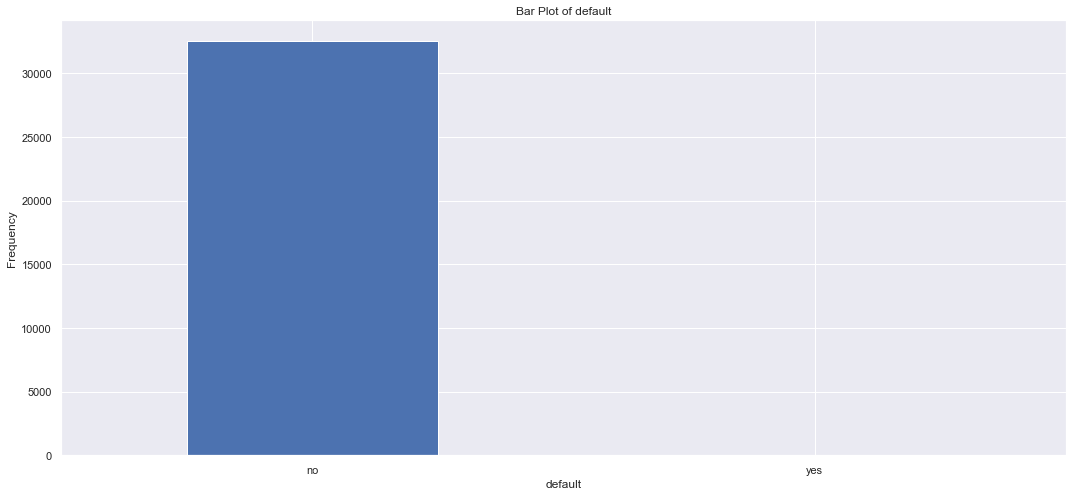

In [104]:
# count the frequency of each value in column_name
value_counts = df['default'].value_counts()

# create a bar plot from the value_counts Series
ax = value_counts.plot(kind='bar', rot=0)

# set the title and x/y labels
ax.set_title('Bar Plot of {}'.format('default'))
ax.set_xlabel('default')
ax.set_ylabel('Frequency')

# display the plot
plt.show()

dikarenakan data default sendiri memiliki arti pernah melakukan kredit macet atau tidak. juga setelah melihat datanya sangat imbalance maka yang kami lakukan adlah tidak akan memasukan kedalam machine learning karena data yang terlalu imbalance dengan perbandingan 30rb banding 3 dan 8rb data unknown/NaN serta tidak dapat ditemukannya data pembantu untuk mengisi data default yang NaN. asumsi kami kredit macet ini tidak akan mempengaruhi keputusan seorang nasabah dalam melakukan deposito dimana deposito ini sendiri adalah sebuah investasi bukan sebuah kredit.

### Feature Engineering

In [105]:
df.drop(columns= ['default','duration'],inplace=True)

#### Education

basic.4y, basic.6y, basic.9y di grouping menjadi basic education.  https://eurydice.eacea.ec.europa.eu/national-education-systems/portugal/organisation-education-system-and-its-structure

In [106]:
lst=['basic.9y','basic.6y','basic.4y']
for i in lst:
    df.loc[df['education'] == i, 'education'] = "basic.education"

df['education'].value_counts()

basic.education        13105
university.degree      12392
high.school            10078
professional.course     5452
illiterate                18
Name: education, dtype: int64

<AxesSubplot:xlabel='education', ylabel='count'>

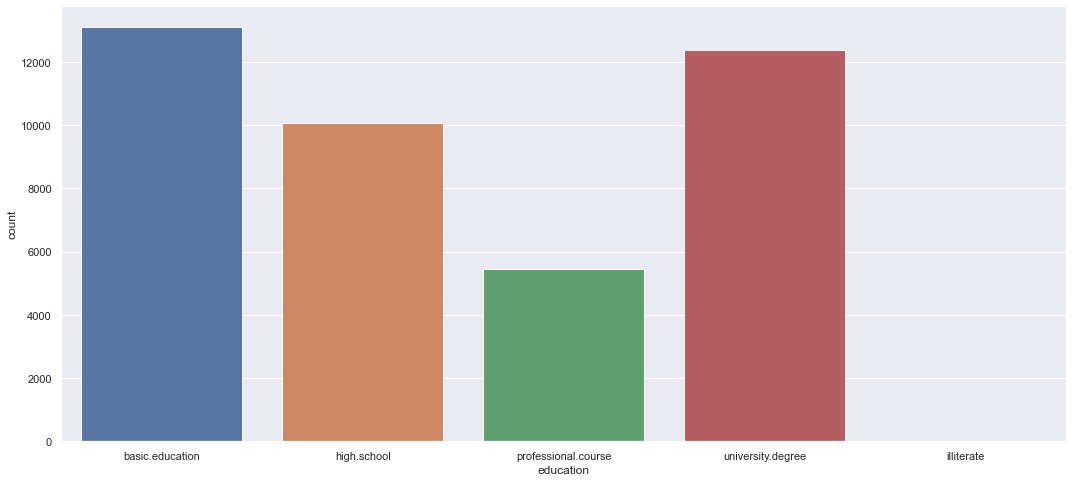

In [107]:
sns.countplot(data = df, x = 'education')

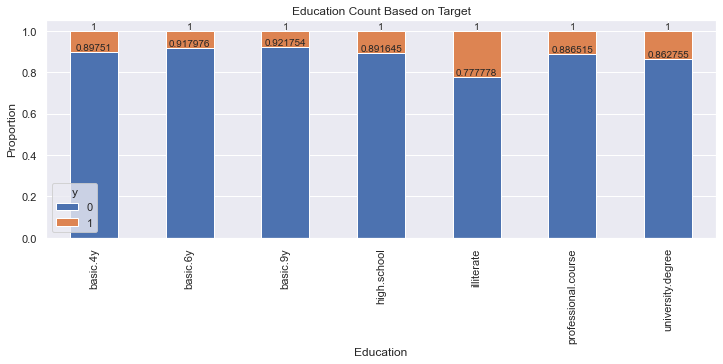

In [108]:
# Compute the frequency of education categories by target 
Default_freq = Default.div(Default.sum(1).astype(float), axis=0)

# Plot the stacked bar chart
ax = Default_freq.plot(kind="bar", stacked=True, figsize=(12,4))

# Add labels to the bars
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=10)

# Add title and axis labels
plt.title('Education Count Based on Target')
plt.xlabel('Education')
plt.ylabel('Proportion')

# Show the plot
plt.show()


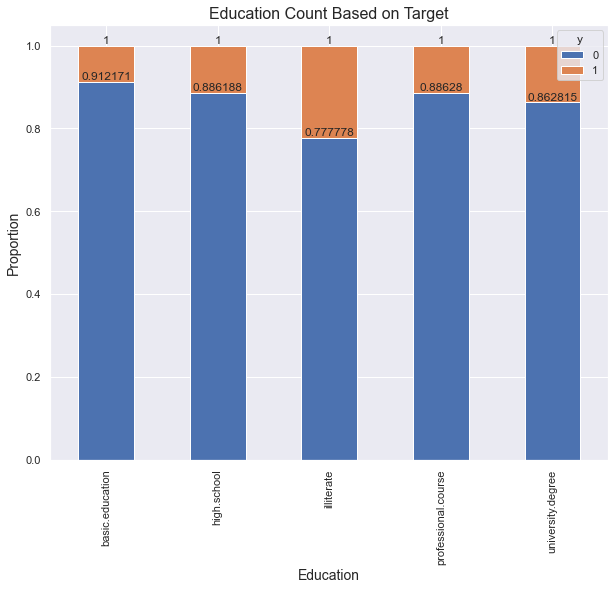

In [109]:
# Compute the frequency of education categories by target
Education = pd.crosstab(df["education"], df['y'])
Education_freq = Education.div(Education.sum(1).astype(float), axis=0)

# Plot the stacked bar chart
ax = Education_freq.plot(kind="bar", stacked=True, figsize=(10,8))

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=12)

# Add title and axis labels
plt.title('Education Count Based on Target', fontsize=16)
plt.xlabel('Education', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

# Show the plot
plt.show()


dilihat setelah dilakukan grouping terdapat perubahan yang tidak terlalu signifikan pada acceptance rate antara sebelum dan sesudah di gouping pada basic education

#### Pdays

In [110]:
df['pdays'] = ["Contacted" if v != 999 else 'Not Contacted' for v in df['pdays']]

Merubah nilai 999 menjadi Not Contacted dan data lainnya menjadi Contacted

In [111]:
df['pdays'].value_counts()

Not Contacted    39537
Contacted         1508
Name: pdays, dtype: int64

<AxesSubplot:xlabel='pdays', ylabel='count'>

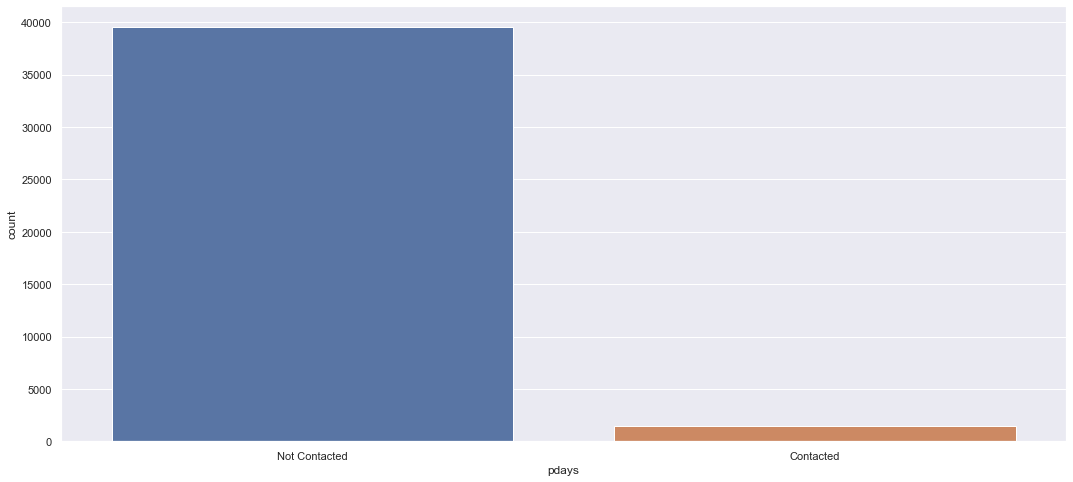

In [112]:
sns.countplot(data = df, x = 'pdays')

Text(0.5, 1.0, 'Pdays count based on target')

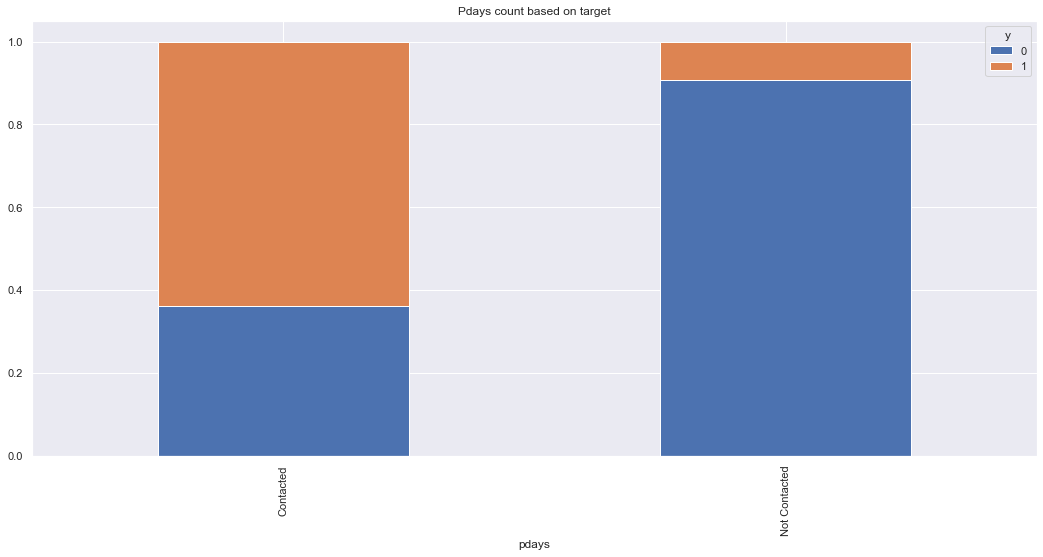

In [113]:
Previous=pd.crosstab(df["pdays"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(18,8)})
plt.title('Pdays count based on target')

Menurut Visualisasi diatas mereka yang telah dikontak memiliki kemungkinan lebih besar untuk membuka rekening term deposit.

#### Campaign

Text(0.5, 1.0, 'Campaign Boxplot with Outlier')

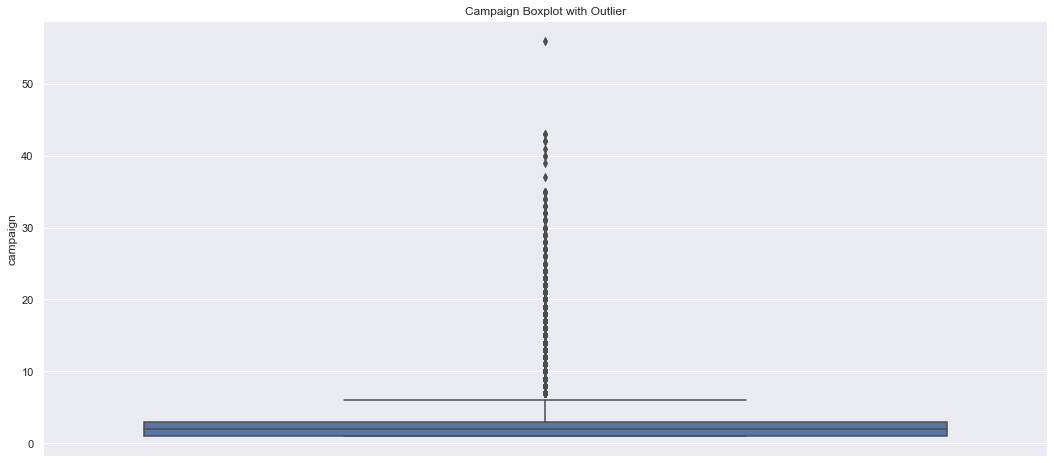

In [114]:
sns.boxplot(data=df , y = 'campaign')
plt.title('Campaign Boxplot with Outlier')

In [115]:
Q1 = df['campaign'].quantile(0.25)
Q3 = df['campaign'].quantile(0.75)
IQR = Q3 - Q1     

filter = (df['campaign'] >= Q1 - 1.5 * IQR) & (df['campaign'] <= Q3 + 1.5 *IQR)
df=df.loc[filter]

Text(0.5, 1.0, 'Campaign Boxplot without Outlier')

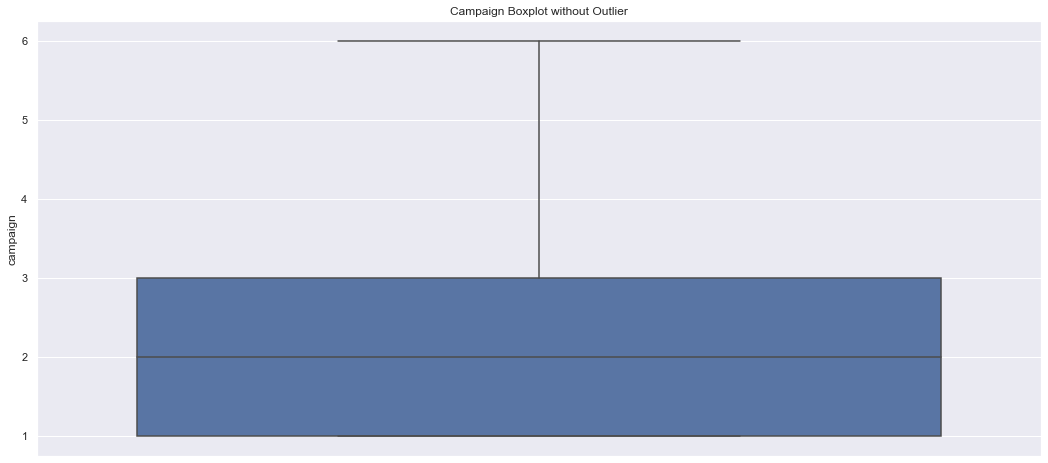

In [116]:
sns.boxplot(data = df , y = 'campaign')
plt.title('Campaign Boxplot without Outlier')

<AxesSubplot:xlabel='campaign', ylabel='count'>

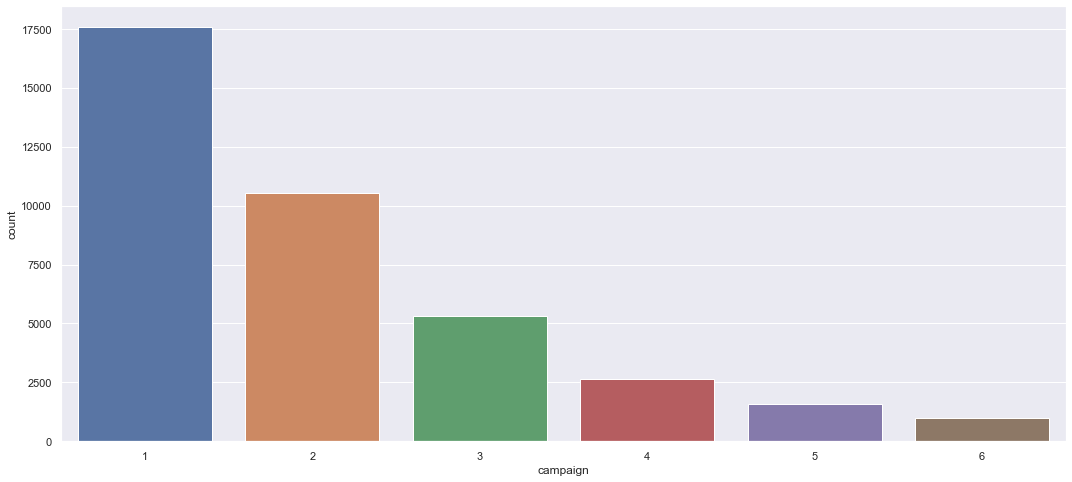

In [117]:
sns.countplot(data = df, x= 'campaign')

Text(0.5, 1.0, 'Campaign count based on target')

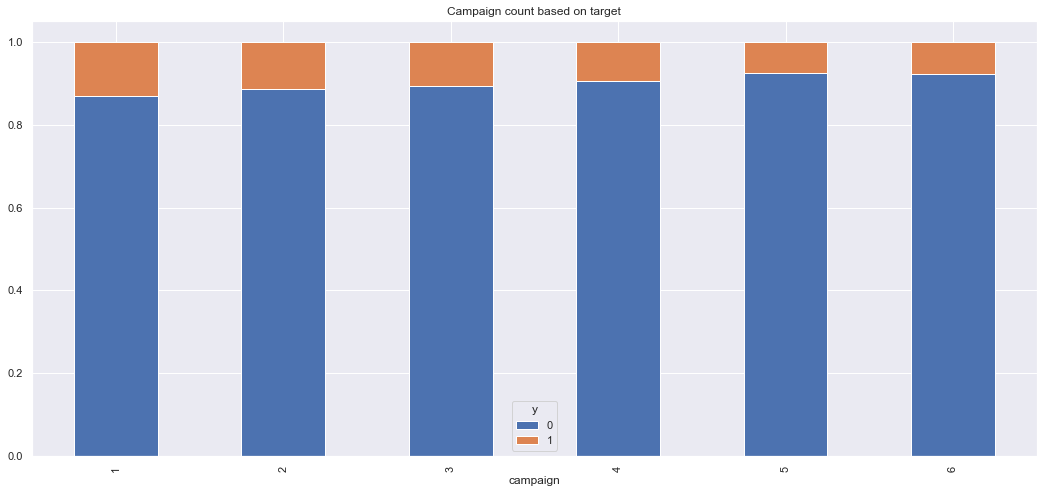

In [118]:
Previous=pd.crosstab(df["campaign"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(18,8)})
plt.title('Campaign count based on target')

In [119]:
df['campaign'] = df['campaign'].astype('O')

Data outlier pada kolom campaign dibuang karena kita ingin meningkatkan jumlah penerimaan penawaran pembukaan rekening term deposit, dengan meminimalkan jumlah kontak penawaran yang dibutuhkan

#### Age

Melakuakan Grouping berdasarka rentang usia

In [120]:
df['age'].nunique()

78

In [121]:
#Grouping by Range
def age(dataframe):
    q1 = 20
    q2 = 30
    q3 = 40
    q4 = 50
    q5 = 60
    q6 = 70
    
    dataframe.loc[(dataframe['age'] < q1), 'age'] = 1
    dataframe.loc[(dataframe['age'] >= q1) & (dataframe['age'] < q2), 'age'] = 2
    dataframe.loc[(dataframe['age'] >= q2) & (dataframe['age'] < q3), 'age'] = 3
    dataframe.loc[(dataframe['age'] >= q3) & (dataframe['age'] < q4), 'age'] = 4
    dataframe.loc[(dataframe['age'] >= q4) & (dataframe['age'] < q5), 'age'] = 5
    dataframe.loc[(dataframe['age'] >= q5) & (dataframe['age'] < q6), 'age'] = 6
    dataframe.loc[(dataframe['age'] >= q6), 'age'] = 7
     
    return dataframe
age(df)

df.head(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,5,housemaid,married,basic.education,no,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,5,services,married,high.school,no,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,3,services,married,high.school,yes,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,4,admin.,married,basic.education,no,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,5,services,married,high.school,no,yes,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [122]:
df['age'] = df['age'].astype('O')

<AxesSubplot:xlabel='age'>

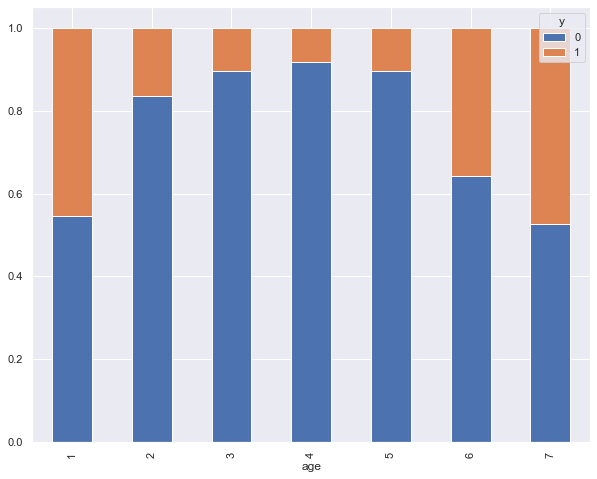

In [123]:
Age=pd.crosstab(df["age"],df['y'])
Age.div(Age.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(10,8))

Berdasarkan visualisi dapat dilihat bawah rentang usia dibawah 20 dan diatas 60 memiliki kemungkinan paling besar untuk melakukan pembukaan rekening deposito.

#### Encoding

In [124]:
lst_object = []

for i in df.columns:
    if df[i].dtype == 'O':
        lst_object.append([i,df[i].nunique(),list(df[i].drop_duplicates().sample(2).values)])
        
pd.DataFrame(data=lst_object,columns=['Columns', 'N Unique','Unique Sample']).sort_values(by=['N Unique']).reset_index()

,index,Columns,N Unique,Unique Sample
0,4,housing,2,"[no, yes]"
1,5,loan,2,"[no, yes]"
2,6,contact,2,"[telephone, cellular]"
3,10,pdays,2,"[Contacted, Not Contacted]"
4,2,marital,3,"[single, divorced]"
5,11,poutcome,3,"[success, nonexistent]"
6,3,education,5,"[basic.education, university.degree]"
7,8,day_of_week,5,"[tue, wed]"
8,9,campaign,6,"[2, 3]"
9,0,age,7,"[7, 1]"


##### 

In [125]:
# Housing
df['housing'] = df['housing'].replace({'no':0,'yes':1})

# Loan
df['loan'] = df['loan'].replace({'no':0,'yes':1})

# Pdays
df['pdays'] = df['pdays'].replace({'Not Contacted':0,'Contacted':1})

In [126]:
df['education'].unique()

array(['basic.education', 'high.school', 'professional.course',
       'university.degree', 'illiterate'], dtype=object)

In [127]:
# Education
df['education'] = df['education'].replace({'illiterate':0,
                                           'basic.education':1,
                                           'high.school':2,
                                           'university.degree':3,
                                           'professional.course':4})


In [128]:
# Month
month_encoder = df['month'].value_counts().to_dict()
df['month'] = df['month'].map(month_encoder)

In [129]:
# Job
job_encoder = df['job'].value_counts().to_dict()
df['job'] = df['job'].map(job_encoder)

In [130]:
df = pd.get_dummies(df)

In [131]:
df.head()

,job,education,housing,loan,month,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_1,age_2,age_3,age_4,age_5,age_6,age_7,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,campaign_1,campaign_2,campaign_3,campaign_4,campaign_5,campaign_6,poutcome_failure,poutcome_nonexistent,poutcome_success
0,986,1,0,0,13075,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1,3737,2,0,0,13075,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,3737,2,1,0,13075,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
3,9823,1,0,0,13075,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4,3737,2,0,1,13075,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0


In [132]:
df.shape

(38654, 39)

### Feature Selection

In [133]:
X_rfecv = df.drop('y', axis=1)
target_rfecv = df['y']

rfc = lgb.LGBMClassifier(random_state=123)
rfecv = RFECV(estimator=rfc, step=1, scoring='accuracy')
rfecv = rfecv.fit(X_rfecv.values, target_rfecv.values)

Optimal number of features: 10


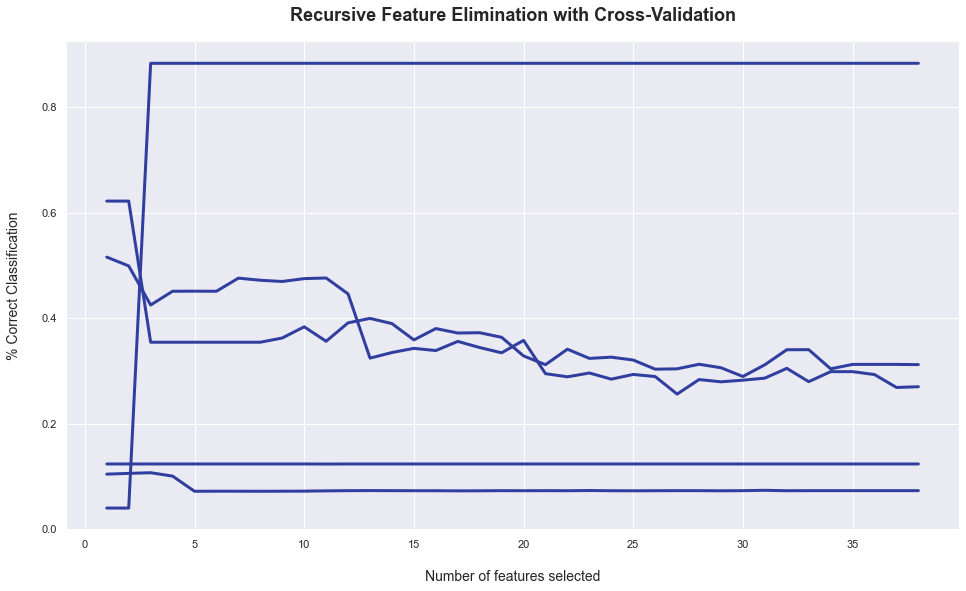

In [134]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [135]:
from numpy import array

mask = rfecv.get_support()
features = array(X_rfecv.columns) 
best_features = features[mask]
 
print("All features: ", X_rfecv.shape[1])
print(features)

print("Selected best: ", best_features.shape[0])
print(features[mask])

All features:  38
['job' 'education' 'housing' 'loan' 'month' 'pdays' 'previous'
 'emp.var.rate' 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed'
 'age_1' 'age_2' 'age_3' 'age_4' 'age_5' 'age_6' 'age_7'
 'marital_divorced' 'marital_married' 'marital_single' 'contact_cellular'
 'contact_telephone' 'day_of_week_fri' 'day_of_week_mon' 'day_of_week_thu'
 'day_of_week_tue' 'day_of_week_wed' 'campaign_1' 'campaign_2'
 'campaign_3' 'campaign_4' 'campaign_5' 'campaign_6' 'poutcome_failure'
 'poutcome_nonexistent' 'poutcome_success']
Selected best:  10
['job' 'education' 'housing' 'month' 'previous' 'cons.price.idx'
 'euribor3m' 'age_3' 'marital_single' 'campaign_1']


In [136]:
bank = df[best_features]

In [137]:
bank

,job,education,housing,month,previous,cons.price.idx,euribor3m,age_3,marital_single,campaign_1
0,986,1,0,13075,0,93.994,4.857,0,0,1
1,3737,2,0,13075,0,93.994,4.857,0,0,1
2,3737,2,1,13075,0,93.994,4.857,1,0,1
3,9823,1,0,13075,0,93.994,4.857,0,0,1
4,3737,2,0,13075,0,93.994,4.857,0,0,1
...,...,...,...,...,...,...,...,...,...,...
41183,1633,4,1,4023,0,94.767,1.028,0,0,1
41184,8826,4,0,4023,0,94.767,1.028,0,0,1
41185,1633,3,1,4023,0,94.767,1.028,0,0,0
41186,6341,4,0,4023,0,94.767,1.028,0,0,1


## Modeling

In [139]:
x = bank
#x = df.drop(columns=['y'],axis = 1)
y = df['y']

In [140]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=123)

In [141]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()
gbc = GradientBoostingClassifier()
gnb = GaussianNB()
bc = BaggingClassifier()
ab = AdaBoostClassifier()

In [142]:
models = [logreg,knn,dt,rf,xgb,lgbm,gbc,gnb,bc,ab]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        #('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM','Gradient Boosting Classifier','Naive Bayes','Bagging Classifier','Adaboost Classifier'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

,mean roc_auc,sdev
model,,
LightGBM,0.789890,0.005552
Gradient Boosting Classifier,0.789297,0.005891
Adaboost Classifier,0.784151,0.006275
XGBoost,0.781476,0.008841
Logistic Regression,0.767757,0.006067
Naive Bayes,0.758041,0.006170
Random Forest,0.744517,0.007085
Bagging Classifier,0.723897,0.006931
KNN,0.716881,0.006881


In [147]:
models = [logreg,knn,dt,rf,xgb,lgbm,gbc,gnb,bc,ab]
scores = []

def y_pred_func(i):
    estimator=Pipeline([
        #('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM','Gradient Boosting Classifier','Naive Bayes','Bagging Classifier','Adaboost Classifier']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    scores.append({'model':j, 'roc_auc_score':roc_auc_score(y_test,y_predict_proba),'f1 score':f1_score(y_test,y_pred)})
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame(scores).set_index('model').sort_values(by='f1 score',ascending = False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      6829
           1       0.73      0.01      0.02       902

    accuracy                           0.88      7731
   macro avg       0.81      0.50      0.48      7731
weighted avg       0.87      0.88      0.83      7731

KNN 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      6829
           1       0.49      0.24      0.33       902

    accuracy                           0.88      7731
   macro avg       0.70      0.61      0.63      7731
weighted avg       0.86      0.88      0.86      7731

Decision Tree 
               precision    recall  f1-score   support

           0       0.91      0.94      0.92      6829
           1       0.38      0.26      0.31       902

    accuracy                           0.86      7731
   macro avg       0.64      0.60      0.62      7731
weighted avg       0.85      0

,roc_auc_score,f1 score
model,,
Naive Bayes,0.765556,0.358909
KNN,0.722107,0.325926
Random Forest,0.754242,0.322214
Bagging Classifier,0.741360,0.316804
XGBoost,0.799807,0.314873
Decision Tree,0.594527,0.311315
Gradient Boosting Classifier,0.801719,0.285479
LightGBM,0.809892,0.268755
Adaboost Classifier,0.796404,0.214789


In [148]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [149]:
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=123)

In [150]:
data = x_train
target = y_train

In [151]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler(random_state = 123, sampling_strategy=0.5)

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    gnb = GaussianNB()
    estimator=Pipeline([
        ('model',gnb)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

In [152]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.861804,0.867443,0.758273,0.755212,0.638122,0.660422,0.323792,0.371191,0.389485,0.422713
1,0.863349,0.860006,0.758322,0.755507,0.641797,0.636184,0.329332,0.324100,0.397179,0.382353
2,0.862666,0.865826,0.756843,0.770716,0.641230,0.639859,0.329948,0.315789,0.394553,0.404255
3,0.863354,0.858344,0.758479,0.755248,0.642011,0.628537,0.329948,0.307479,0.397331,0.371237
4,0.863174,0.855110,0.758850,0.753651,0.642651,0.632727,0.332410,0.329640,0.397205,0.366154
5,0.862456,0.868693,0.758988,0.753448,0.639497,0.650059,0.325639,0.335180,0.392579,0.421603
6,0.862420,0.858991,0.758669,0.750450,0.641050,0.636993,0.330255,0.329640,0.393617,0.380192
7,0.862635,0.867400,0.757084,0.768432,0.639595,0.649474,0.325331,0.337950,0.393229,0.416382
8,0.863857,0.861902,0.758435,0.761144,0.643645,0.633456,0.333026,0.310249,0.400148,0.386207
9,0.863102,0.861578,0.758634,0.755707,0.642146,0.637983,0.331179,0.324100,0.396609,0.388704


In [153]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.740799,0.793404,0.757825,0.755214,0.699855,0.633228,0.557201,0.567867,0.624647,0.297965
1,0.741830,0.798901,0.759609,0.756056,0.702473,0.641625,0.567209,0.584488,0.624026,0.308931
2,0.741640,0.802780,0.761131,0.770857,0.702370,0.644176,0.567616,0.578947,0.623525,0.313343
3,0.742413,0.805304,0.757463,0.755607,0.703171,0.640356,0.568221,0.548476,0.624966,0.310832
4,0.742983,0.790750,0.760986,0.753712,0.704397,0.626340,0.572533,0.545706,0.624956,0.289706
5,0.738643,0.808215,0.756034,0.754290,0.698104,0.638977,0.558295,0.529086,0.619874,0.311075
6,0.741464,0.797219,0.759390,0.750854,0.701526,0.638444,0.563502,0.576177,0.624301,0.304985
7,0.746318,0.796895,0.762564,0.769203,0.707804,0.638696,0.574892,0.578947,0.631175,0.305109
8,0.745098,0.795925,0.762673,0.761676,0.706285,0.634459,0.572370,0.562327,0.629361,0.300296
9,0.737965,0.796248,0.755560,0.755513,0.696783,0.633057,0.554145,0.554017,0.619576,0.298954


In [154]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      2732
           1       0.30      0.57      0.39       361

    accuracy                           0.79      3093
   macro avg       0.62      0.70      0.63      3093
weighted avg       0.86      0.79      0.82      3093

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      2732
           1       0.31      0.58      0.40       361

    accuracy                           0.80      3093
   macro avg       0.62      0.71      0.64      3093
weighted avg       0.86      0.80      0.82      3093

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      2732
           1       0.31      0.58      0.41       361

    accuracy                           0.80      3093
   macro avg       0.63      0.71      0.64      3093
weighted avg       0.86      0.80      0.83      3093

              preci

### Hyperparameter Tuning

In [155]:
gnb = GaussianNB()

estimator=Pipeline([
    ('model',gnb)
])

In [156]:
# hyperparam_space=[{
#     'model__max_bin': [255, 275, 300, 230],
#     'model__num_leaves':[31, 21, 41, 51],
#     'model__min_data_in_leaf': [20, 15, 30, 40],
#     'model__num_iterations':[100,75, 125, 150],
#     'model__learning_rate': [0.1, 0.075, 0.125, 0.05],
#     'model__random_state': [123]
# }]

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [157]:
# grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring='roc_auc', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=123))

In [158]:
# grid.fit(x_train,y_train)
# print(grid.best_score_)
# print(grid.best_params_)

In [160]:
grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
grid.fit(x_train, y_train)
print(grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=5.336699231206302e-08)


In [161]:
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)

GaussianNB(var_smoothing=5.336699231206302e-08)

In [ ]:
estimator=Pipeline([
    #('oversampling',ros),
    #('preprocess',transformer),
    ('model',gnb)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=123)),
                ('model', LGBMClassifier())])

In [ ]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default LGBM : ', roc_auc_default)
print('ROC AUC Score Tuned LGBM : ', roc_auc_tuned)

ROC AUC Score Default LGBM :  0.8162527651248637
ROC AUC Score Tuned LGBM :  0.8202128232959802


In [ ]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.95      0.87      0.91      6829
           1       0.40      0.64      0.49       902

    accuracy                           0.85      7731
   macro avg       0.68      0.76      0.70      7731
weighted avg       0.88      0.85      0.86      7731

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.95      0.87      0.91      6829
           1       0.40      0.65      0.49       902

    accuracy                           0.84      7731
   macro avg       0.67      0.76      0.70      7731
weighted avg       0.88      0.84      0.86      7731



### Threshold Tuning

In [ ]:
best_model.fit(x_train,y_train)
y_pred = best_model.predict_proba(x_test)
y_pred = y_pred[:,1]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


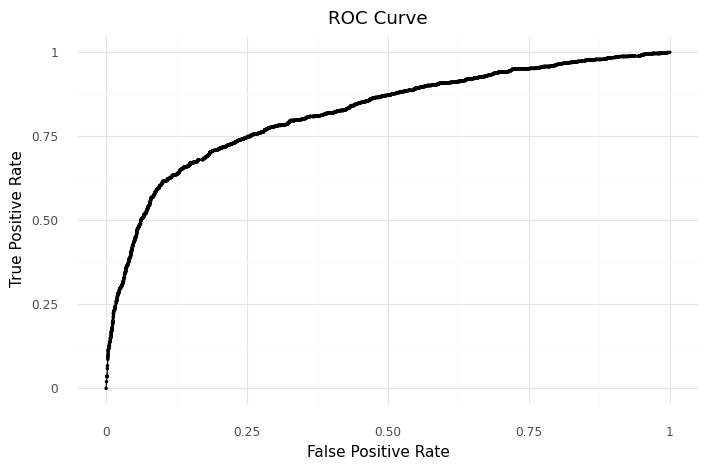

<ggplot: (170188120155)>

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Create the data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

Best Threshold: 0.3999 with G-Mean: 0.7575
FPR: 0.1888, TPR: 0.7073


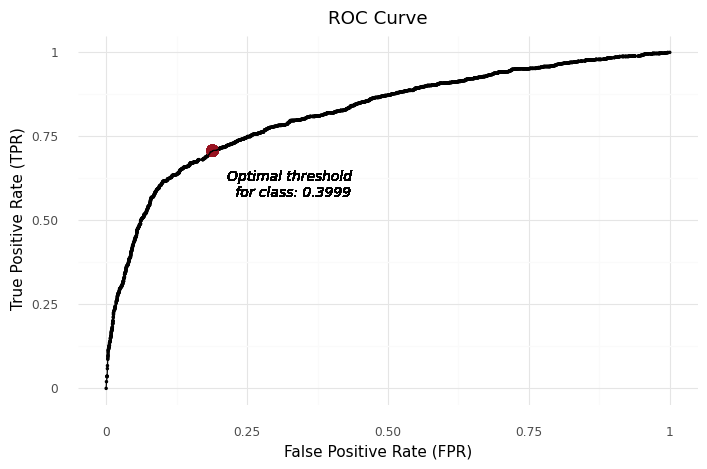

<ggplot: (170303335415)>

In [ ]:
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Best Threshold: 0.4744 with Youden J statistic: 0.7554
FPR: 0.1492, TPR: 0.6707


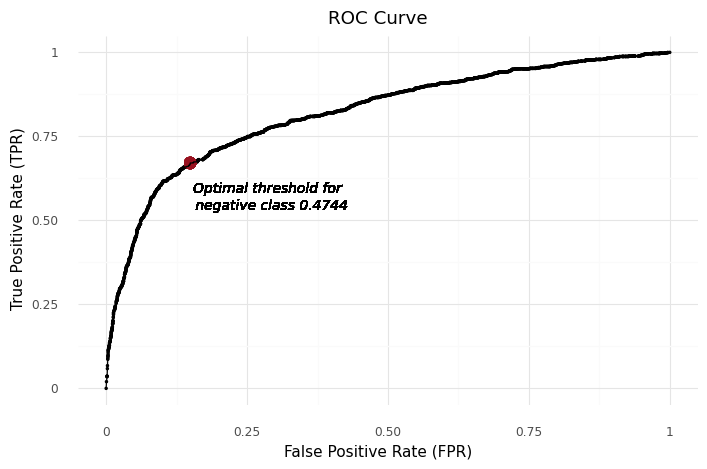

<ggplot: (170189786621)>

In [ ]:
youdenJ = tpr - fpr

# Find the optimal threshold
index = np.argmax(youdenJ)
thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    # Annotate the text
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold for \n negative class {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

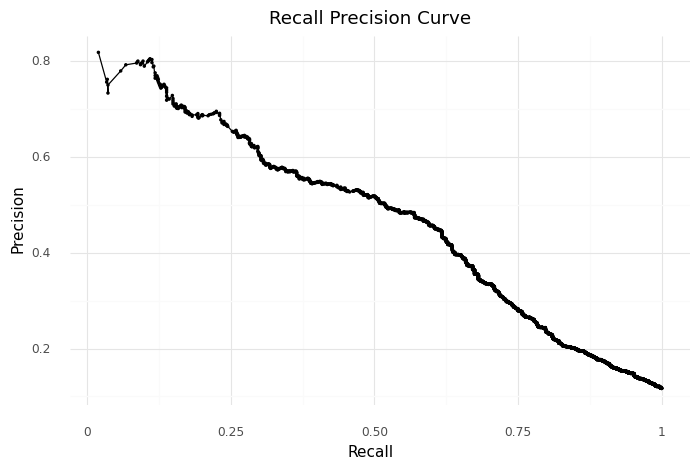

<ggplot: (170188739575)>

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot the ROC curve
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})
df_recall_precision.head()

# Creat a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Best Threshold: 0.6985 with F-Score: 0.5229
Recall: 0.5687, Precision: 0.484


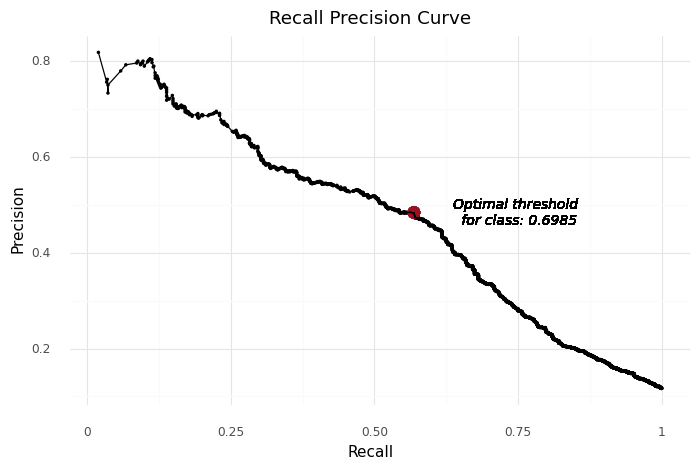

<ggplot: (170191041193)>

In [ ]:
fscore = (2 * precision * recall) / (precision + recall)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # Annotate the text
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Length of sequence: 10000
Best Threshold: 0.6981 with F-Score: 0.5229


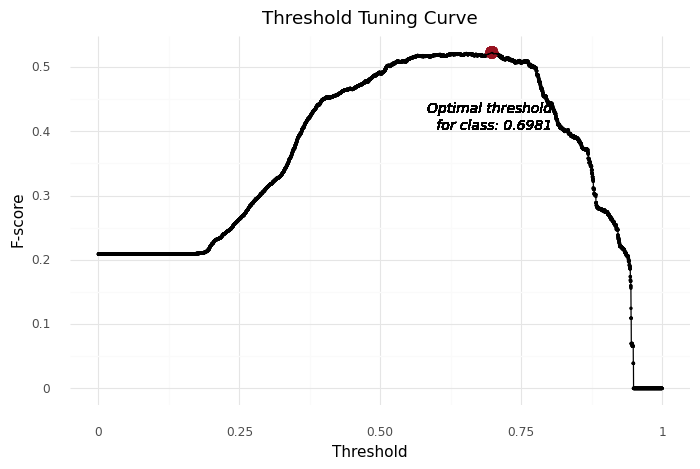

<ggplot: (170189292626)>

In [ ]:
thresholds = np.arange(0.0, 1.0, 0.0001)
fscore = np.zeros(shape=(len(thresholds)))
print('Length of sequence: {}'.format(len(thresholds)))

# Fit the model
for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (y_pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(y_test, y_pred_prob)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

# Plot the threshold tuning
df_threshold_tuning = pd.DataFrame({'F-score':fscore,
                                    'Threshold':thresholds})
df_threshold_tuning.head()

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_threshold_tuning)+
    geom_point(aes(x = 'Threshold',
                   y = 'F-score'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = thresholdOpt,
                   y = fscoreOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Threshold',
                   y = 'F-score'))+
    # Annotate the text
    geom_text(aes(x = thresholdOpt,
                  y = fscoreOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Threshold Tuning Curve')+
    xlab('Threshold')+
    ylab('F-score')+
    theme_minimal()
)

In [ ]:
print(classification_report(y_test,y_pred_tuned))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      6829
           1       0.40      0.65      0.49       902

    accuracy                           0.84      7731
   macro avg       0.67      0.76      0.70      7731
weighted avg       0.88      0.84      0.86      7731



In [ ]:
decisions = (best_model.predict_proba(x_test)[:,1] >= thresholdOpt).astype(int)

In [ ]:
print(classification_report(y_test,decisions))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6829
           1       0.48      0.57      0.52       902

    accuracy                           0.88      7731
   macro avg       0.71      0.74      0.73      7731
weighted avg       0.89      0.88      0.88      7731



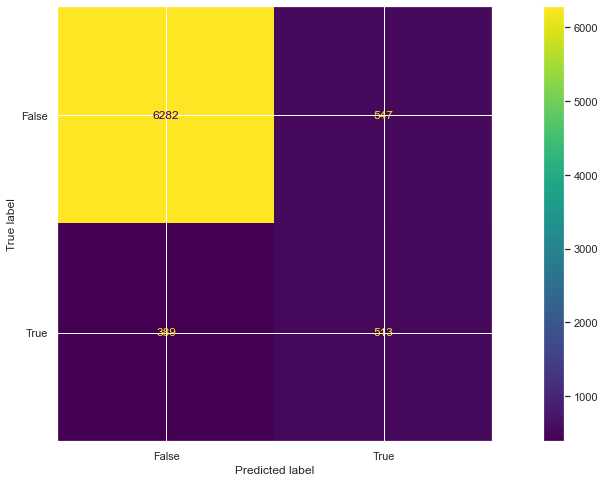

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, decisions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
matthews_corrcoef(y_test, decisions)


0.45605727290350473

### Feature Importances

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model LGBM kita

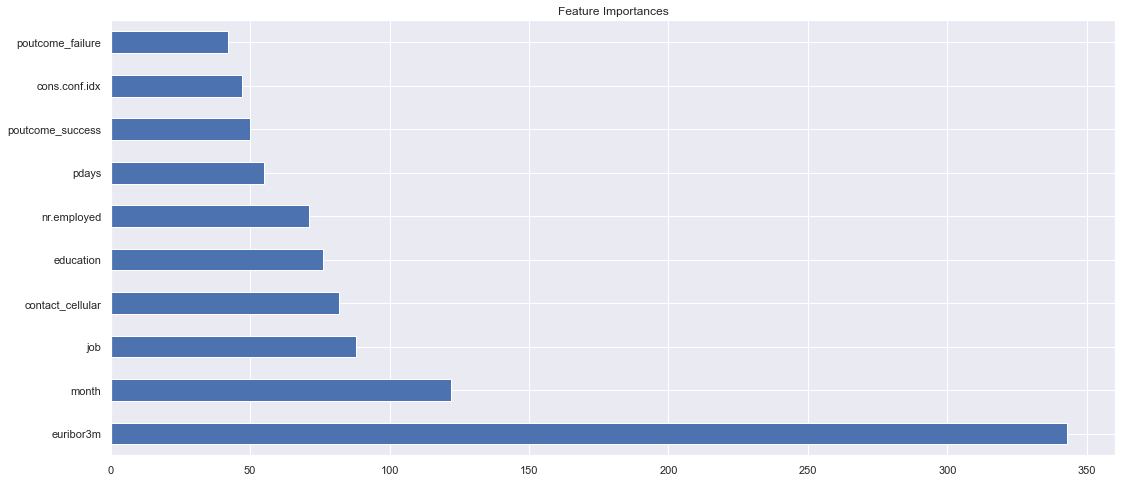

In [ ]:
coef1 = pd.Series(best_model['model'].feature_importances_,index = data.columns).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

# Conclusion & Recomenndation

dari classification report dari tuned LGBM didapatkan data bahwa didapatkan hasil f1 score sebesar 52% untuk class 1 (yes) dimana ini merupakan hasil yang cukup/OK berdasarkan https://stephenallwright.com/interpret-f1-score/#:~:text=F1%20score%20can%20be%20interpreted,it%20does%20capture%20(precision). juga secara macro avg dari model didapatkan nilai 0.73/ 70% dimana ini merupakan hasil yang OK/cukup. maka dapat disimpulkan bahwa model memiliki kemampuan presisi dan recall yang cukup pada setiap kelasnya. penggunaan macro average ini didasari oleh imbalance data class agar f1 scorenya tidak dibantu oleh supportnya sehingga hasilnya se real mungkin.

dalam implementasinya model akan seperti ini. jika melakukan telemarketing biaya permenitnya adalah 19cent/0.19EUR berdasarakan https://digital-strategy.ec.europa.eu/en/faqs/calling-and-texting-other-eu-countries-questions-answers dan apabila durasi setiap dilakukannya campaign yaitu 60 mnt per 1 customer. dan dilakukan terhadap 7713 customer akan memakan biaya sebanyak 87,928.2 EUR atau Rp.1,434,268,074.46

dari confussion metric diatas dapat disimpulkan bahwa model dapat memprediksi 6282 customer yang tidak akan melakukan deposito dari data ini saja sudah dapat dipastikan model dapat menghemat 6282x60x0.19EUR = 71,614.8EUR atau Rp.1,168,396,006.99 dari 7713 customer yang akan di lakukan campaign. maka biaya yang harus di keluarkan oleh bank dalam mencari customer potensial hanya :Rp. 265,872,067.47

## Recomendation

Dalam model kami masih banyak hal hal yang perlu di perkuat dan di perbaiki

1. dari data yang tersedia masih kurangnya fitur fitur yang benar benar dapat membantu model karena setelah dilakukan RFeCV hanya didapatkan 10 fitur yang berpengaruh terhadap model.
2. dari sisi coding sendiri masih bisa diperkuat di bagian hyperparameter tuning untuk menambah lebih banyak parameter agar didapatkan hasil yang lebih maksimal
3. survey pun harus dilakukan lebih banyak fitur fitur pendukung karena pada data ini banyak fitur pendukung yang tidak digunakan.
4. hasil dari model ini diharapkan dapat memberikan data baru yang tidak seimbalance survey tanpa model.